In [1]:
%load_ext autoreload 
import numpy as np
from tqdm import tqdm
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from copy import copy
from collections import defaultdict, Counter
from sklearn.metrics import adjusted_rand_score, silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering, DBSCAN
#from sklearn_extra.cluster import KMedoids
from joblib import Parallel, delayed

from hdbscan import validity_index as DBCV
from hdbscan import HDBSCAN
from clustering_utils import clustering_by_methods,\
                             clustering,\
                             plot_clustering_scatter,\
                             davies_bouldin_score_precomputed,\
                             prediction_strength_CV_precomputed

from utils import coord_to_pix, entropy
from IPython.display import clear_output

import warnings
warnings.simplefilter("ignore")
%autoreload 2

# see paper for the thresholds explanation
DBIND_THRESHOLD = 0.6
DBIND_MAX = 3.
SILHOUETTE_THRESH = 0.5
PS_THRESHOLD = 0.8
DBCV_THRESHOLD = 0.0
DATA_PRESERVED_THRESHOLD = 0.9

# Load data

In [2]:
CPT = 0.01 # minimal percentage of the data in single cluster
DATA_SPECIFICATION = 'data_processed_small'
import os
clustering_results_root = f'results/clustering_cpt-{CPT}' + '_small_datasets'

if not os.path.exists(clustering_results_root):
    os.makedirs(clustering_results_root)

In [3]:
datasets_names = ['PLSF', 'StCh', 'Buff', 'Champ', 'Conest', 'rotor', 'otherLake']
tax_names = ['g']

data_orig = {}
for dataset_name in tqdm(datasets_names):
    for tax in tax_names: 
        dataframe = pd.read_csv(f'./data_processed_small/{dataset_name}_{tax}.csv', sep=',')
        label = f'{dataset_name}_{tax}'
        data_orig[label] = dataframe.drop('Unnamed: 0', axis=1).values
    
data_pca = {}
for dataset_name in tqdm(datasets_names):
    for tax in tax_names: 
        label = f'{dataset_name}_{tax}'
        data_pca[label] = np.genfromtxt(f'./results/pca/{label}', delimiter=';')

    
distance_root = f'distances_processed'
distances_names = ['L1', 'L2', 'JS', 'BC']

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 547.99it/s]


# Clustering: precomputed distances

In [4]:
distances_orig = defaultdict(dict)
for metric_name in distances_names:
    for label in data_orig.keys(): 
        distances_orig[metric_name][label] = np.load(os.path.join(distance_root,\
                                                                  f'orig_{metric_name}_{label}.npy'), 
                                                     allow_pickle=True)

In [5]:
class SpectralClustering_prec:
    def __init__(self, *args, **kwargs):
        self.method = SpectralClustering(*args, **kwargs, affinity='precomputed', random_state=42)
    def fit_predict(self, X):
        '''
        X - pairwise_distance matrix
        '''
        A = np.exp(-self.method.gamma * np.abs(X))
        return self.method.fit_predict(A)

# PAM on JS

In [44]:
from sklearn_extra.cluster import KMedoids
results_JS_PAM = {}
pam_method_params = {'n_clusters':None,
                    'method':'pam',
                    'metric':'precomputed',
                    'init':'k-medoids++',
                    'random_state':42}

for (label,D) in distances_orig['JS'].items():
    
    results_per_k = {}
    
    k = 3

    pam_method_params_k = pam_method_params.copy()
    pam_method_params_k['n_clusters'] = k
    method = KMedoids(**pam_method_params_k)
    labels = method.fit_predict(D)
    X = data_pca[label]

    results_per_k['labels'] = labels
    results_per_k['dbind'] = davies_bouldin_score_precomputed(D, labels)
    results_per_k['silh'] = silhouette_score(D, labels, metric='precomputed')
    results_per_k['dbcv'] = DBCV(D, labels, metric='precomputed', d=data_orig[label].shape[1])
    results_per_k['ps'] = prediction_strength_CV_precomputed(D, method=None, y=labels)

    # data mass distribution
    n = len(np.unique(labels))
    cl_dist = np.ones(n)
    for i in range(n):
        cl_dist[i] = sum(labels == i)/len(labels)

    results_per_k['entropy'] = entropy(cl_dist)
    
    results_JS_PAM[label] = results_per_k

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [45]:
pd.DataFrame(results_JS_PAM).T[['dbind', 'silh', 'dbcv', 'ps', 'entropy']]

dbind      silh      dbcv        ps   entropy
PLSF_g  1.003933   0.34873 -0.636193  0.727706  1.073466
StCh_g  1.696753  0.237059 -0.285916  0.611111  0.952078
Buff_g  1.286532  0.302069 -0.416169  0.439744   1.05492

In [8]:
from sklearn_extra.cluster import KMedoids
results_JS_PAM = {}
pam_method_params = {'n_clusters':None,
                    'method':'pam',
                    'metric':'precomputed',
                    'init':'k-medoids++',
                    'random_state':42}

for (label,D) in distances_orig['JS'].items():
    
    results_per_k = {}
    
    k = 3

    pam_method_params_k = pam_method_params.copy()
    pam_method_params_k['n_clusters'] = k
    method = KMedoids(**pam_method_params_k)
    labels = method.fit_predict(D)
    X = data_pca[label]

    results_per_k['labels'] = labels
    results_per_k['dbind'] = davies_bouldin_score_precomputed(D, labels)
    results_per_k['silh'] = silhouette_score(D, labels, metric='precomputed')
    results_per_k['dbcv'] = DBCV(D, labels, metric='precomputed', d=data_orig[label].shape[1])
    results_per_k['ps'] = prediction_strength_CV_precomputed(D, method=None, y=labels)

    # data mass distribution
    n = len(np.unique(labels))
    cl_dist = np.ones(n)
    for i in range(n):
        cl_dist[i] = sum(labels == i)/len(labels)

    results_per_k['entropy'] = entropy(cl_dist)
    
    results_JS_PAM[label] = results_per_k

locs = {
    'PLSF_g': 'best',
   # 'StCh_g': (-0.15, 0.57),
   # 'Buff_g': (-0.15, 0.57)
}


for label, results_label in results_JS_PAM.items():

    X = data_pca[label]
    y = results_label['labels']

    ent = results_label['entropy']
    silh = results_label['silh']
    dbind = results_label['dbind']
    dbcv = results_label['dbcv']
    ps = results_label['ps']

    plt.figure(figsize=(5,5), dpi=300)

    plt.scatter(
                X[:,0], 
                X[:,1],
                c=y,
                edgecolors='black',
                s=40,
                alpha=0.8,
               )

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.xticks([])
    plt.yticks([])
    
    plt.rcParams.update({'font.size': 20, 'axes.titley':1.05})
    
    handles, labels = plt.gca().get_legend_handles_labels()

    text_handle = mlines.Line2D([], [], color='none', label='Entropy: {:.2f}'.format(ent))
    handles.append(text_handle)

    text_handle = mlines.Line2D([], [], color='none', label='Silhouette: {:.2f}'.format(silh))
    handles.append(text_handle)

    text_handle = mlines.Line2D([], [], color='none', label='DB-index: {:.2f}'.format(dbind))
    handles.append(text_handle)

    text_handle = mlines.Line2D([], [], color='none', label='DBCV: {:.2f}'.format(dbcv))
    handles.append(text_handle)

    text_handle = mlines.Line2D([], [], color='none', label='Pred. strength: {:.2f}'.format(ps))
    handles.append(text_handle)


    # Add the arbitrary information patch to the legend handles
    legend = plt.legend(handles=handles, 
                        loc=locs[label], 
                        fontsize=15, 
                        frameon=True, 
                        fancybox=True, 
                        framealpha=0.0)
    
    dataset_name = label.split('_')[0]
    plt.title(f'{dataset_name}, tax: G, JS, \n Partition Around Medoids', fontsize=20, y=1.01)
    
    plt.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# Dist clust

In [9]:

methods_dict_distances = {
                           'HDBSCAN':[HDBSCAN, 
                              {
                               'min_cluster_size':list(range(4,30)), 
                                  'alpha':[0.01, 0.5, 1., 1.5, 2.0],
                               'cluster_selection_epsilon': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
                              'min_samples':[None]+list(range(2,10)),
                               'metric':['precomputed'],
                               'core_dist_n_jobs':[1],
                               'random_state':[42]}
                               ],
                           'KMedoids':[KMedoids, 
                                       {'n_clusters':np.arange(2, 10, 1),
                                        'method':['pam'],
                                        'metric':['precomputed'],
                                        'init':['k-medoids++'],
                                        'random_state':[42]}],
                           'SpectralClustering':[SpectralClustering_prec, 
                                                 {'n_clusters':np.arange(2, 10, 1), 
                                                  'gamma': np.linspace(1,7,num=10),
                                                  'eigen_tol':[1e-4]}]
                        }

In [10]:
for distance_name, distance_dict in tqdm(distances_orig.items()):
    
    results_path = os.path.join(clustering_results_root, f'{distance_name}_cluster_results')
    
    if os.path.isfile(results_path + '.npy'):
        print(f'{results_path} exists, skipping...')
        continue
    
    distance_cluster_results = defaultdict(dict)
    
    '''
    list of dicts [
                  dataset_1 ->  {'method1':[partition1, partition2], ...}
                    , ...., 
                  dataset_n ->  {'method1':[partition1, partition2], ...}
                  ]
    
    '''
    clustering_data_results = Parallel(n_jobs=len(distance_dict),
                                       mmap_mode='w+')(delayed(clustering_by_methods)(data.astype('double'), 
                                                                                      methods_dict_distances,
                                                                                      precomputed=True,
                                                                                      d=data_orig[label].shape[1],
                                                                                      cluster_perc_threshold=CPT)
                                                            for label, data in distance_dict.items())

    # create compatible metrics dicts
    for i,label in enumerate(distance_dict.keys()):
        for j, method_name in enumerate(methods_dict_distances.keys()):
            distance_cluster_results[label][method_name] = clustering_data_results[i][method_name]

    np.save(results_path, distance_cluster_results)
    
clear_output()

  0%|                                                                                                                | 0/4 [00:00<?, ?it/s]

results/clustering_cpt-0.01_small_datasets/L1_cluster_results exists, skipping...
results/clustering_cpt-0.01_small_datasets/L2_cluster_results exists, skipping...


/Users/leydenfernandez/anaconda3/envs/microbiome/lib/python3.9/site-packages/hdbscan/validity.py:33: RuntimeWarning: invalid value encountered in true_divide
  result /= distance_matrix.shape[0] - 1
/Users/leydenfernandez/anaconda3/envs/microbiome/lib/python3.9/site-packages/hdbscan/validity.py:33: RuntimeWarning: invalid value encountered in true_divide
  result /= distance_matrix.shape[0] - 1
/Users/leydenfernandez/anaconda3/envs/microbiome/lib/python3.9/site-packages/hdbscan/validity.py:33: RuntimeWarning: invalid value encountered in true_divide
  result /= distance_matrix.shape[0] - 1
/Users/leydenfernandez/anaconda3/envs/microbiome/lib/python3.9/site-packages/hdbscan/validity.py:33: RuntimeWarning: invalid value encountered in true_divide
  result /= distance_matrix.shape[0] - 1
/Users/leydenfernandez/anaconda3/envs/microbiome/lib/python3.9/site-packages/hdbscan/validity.py:33: RuntimeWarning: invalid value encountered in true_divide
  result /= distance_matrix.shape[0] - 1
/User

KeyboardInterrupt: 

# Clustering: PCA

In [11]:
methods_dict = {
               'HDBSCAN':[HDBSCAN, 
                  {
                   'min_cluster_size':list(range(4,30)), 
                   'alpha':[0.01, 0.5, 1., 1.5, 2.0],
                   'cluster_selection_epsilon': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
                  'min_samples':[None]+list(range(2,30)),
                   'core_dist_n_jobs':[1]}
                   ],
               'KMedoids':[KMedoids, 
                           {'n_clusters':np.arange(2, 10, 1),
                            'method':['pam'],
                            'init':['k-medoids++'],
                            'random_state':[42]}],
               'SpectralClustering':[SpectralClustering, 
                                     {'n_clusters':np.arange(2, 10, 1),
                                      'affinity':['nearest_neighbors'],
                                      'n_neighbors': list(range(1,30,2)), 
                                     'eigen_tol':[1e-4],
                                     'random_state':[42]}]
             }

In [12]:
results_path = os.path.join(clustering_results_root, f'pca_cluster_results')

pca_cluster_results = defaultdict(dict)

clustering_data_results = Parallel(n_jobs=len(data_pca),
                                   mmap_mode='w+')(delayed(clustering_by_methods)(data.astype('double'), 
                                                                                  methods_dict,
                                                                                  precomputed=False,
                                                                                  d=data.shape[1],
                                                                                  cluster_perc_threshold=CPT)
                                                        for label, data in data_pca.items())

# create compatible metrics dicts
for i,label in enumerate(data_pca.keys()):
    for j, method_name in enumerate(methods_dict.keys()):
        pca_cluster_results[label][method_name] = clustering_data_results[i][method_name]

np.save(results_path, pca_cluster_results)

clear_output()

# Load clustering results

In [13]:
representations_names = np.unique(list(map(lambda x: x.split('_')[0], os.listdir(clustering_results_root))))

clustering_results_df = []

for representation in representations_names:
    
    clustreing_results_path = os.path.join(clustering_results_root, f'{representation}_cluster_results.npy')
    cluster_results = np.load(clustreing_results_path, allow_pickle=True).item()
    
    # results for each datset
    for label, cl_res_label in cluster_results.items():
        #results for each method given dataset
        for cl_method, cl_res_label_method in cl_res_label.items():
            
            if len(cl_res_label_method) == 0:
                print('Empty results for:', representation, label, cl_method)
                continue
                
            df = pd.DataFrame(cl_res_label_method)
            
#             cl_res_label_method_ = {k:v[0] for k,v in cl_res_label_method.items()}
#             df = pd.DataFrame(cl_res_label_method_).T
            
            dataset, tax = label.split('_')
            
            df['dataset'] = dataset
            df['tax'] = tax
            df['representation'] = representation
            df['cl_method'] = cl_method
            # n_clusters found
            n_unique = lambda x: len(np.unique(x[x!=-1]))
            df['n_cl'] = df['labels'].apply(n_unique)
            
            clustering_results_df.append(df)
            
clustering_results_df = pd.concat(clustering_results_df, axis=0, ignore_index=True)

Empty results for: pca StCh_g HDBSCAN


In [14]:
df_mask = (clustering_results_df['data_used'] > DATA_PRESERVED_THRESHOLD) &\
          (clustering_results_df['dbind'] < DBIND_MAX)  &\
          (~clustering_results_df['dbcv'].isna())

clustering_results_df_ = clustering_results_df[df_mask]

# Davies-Bouldin index and Silhoutte score, entropy coloring

In [15]:
nice_repr = {'tsne':'t-SNE',
             'umap':'UMAP',
             'spectral':'SE',
             'L2':'L2'}

nice_cl = {'SpectralClustering':'Spectral cl.',
           'HDBSCAN':'HDBSCAN'}

## PLSF

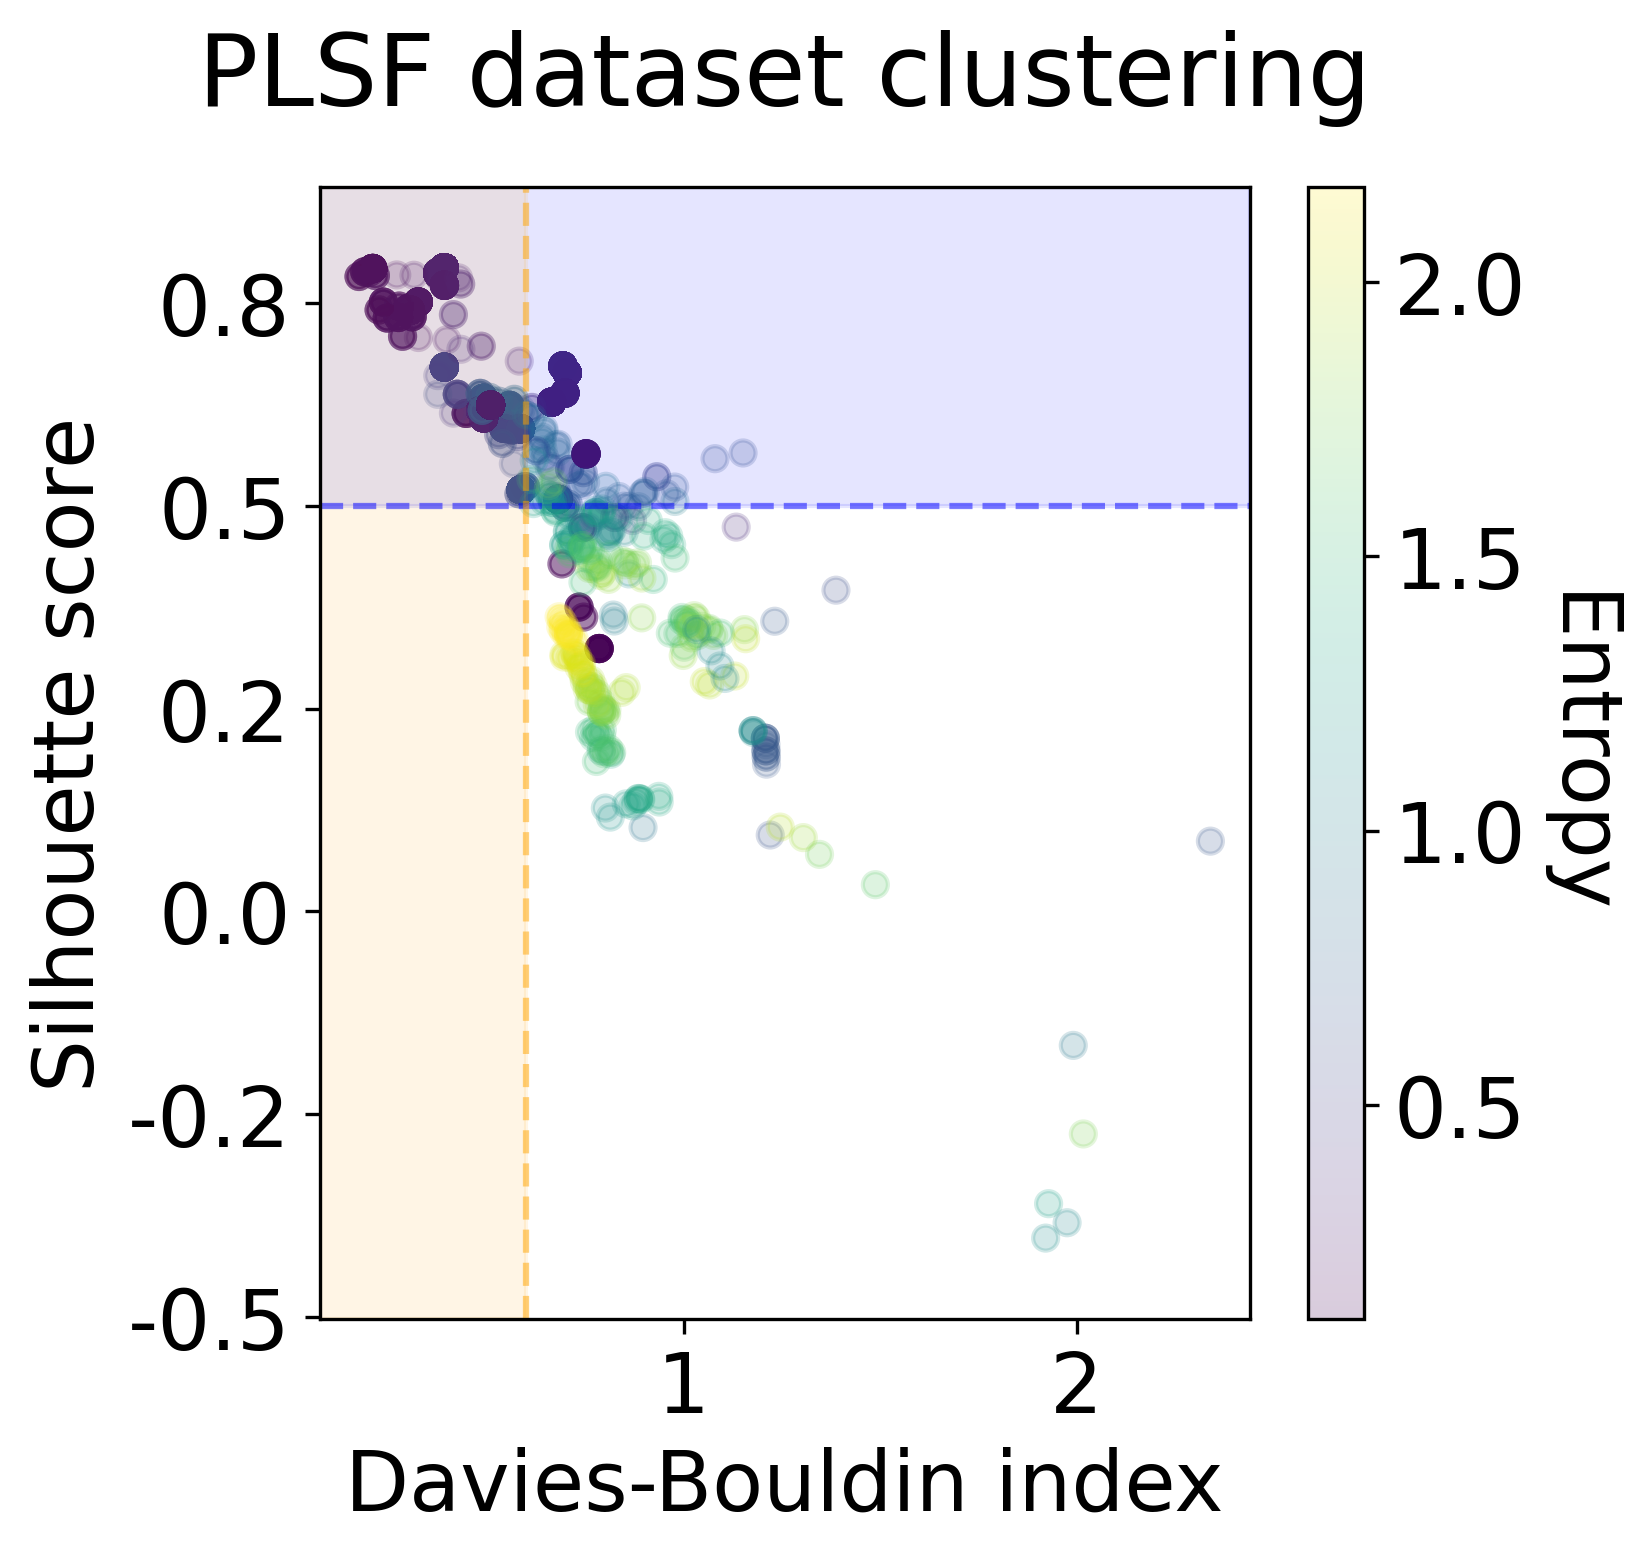

In [16]:

plt.rcParams.update({'font.size': 20, 'axes.titley':1.05})

PLSF_df_silh = clustering_results_df_.query('dataset == "PLSF"')

plot_clustering_scatter(PLSF_df_silh, 
                        x_metric_name='dbind',
                        y_metric_name='silh', 
                        coloring_metric_name='entropy', 
                        title='PLSF dataset clustering',
                        y_threshold=SILHOUETTE_THRESH,
                        x_threshold=DBIND_THRESHOLD,
                        y_hue_line=1,
                        x_hue_line=0)

KeyError: 'pca'

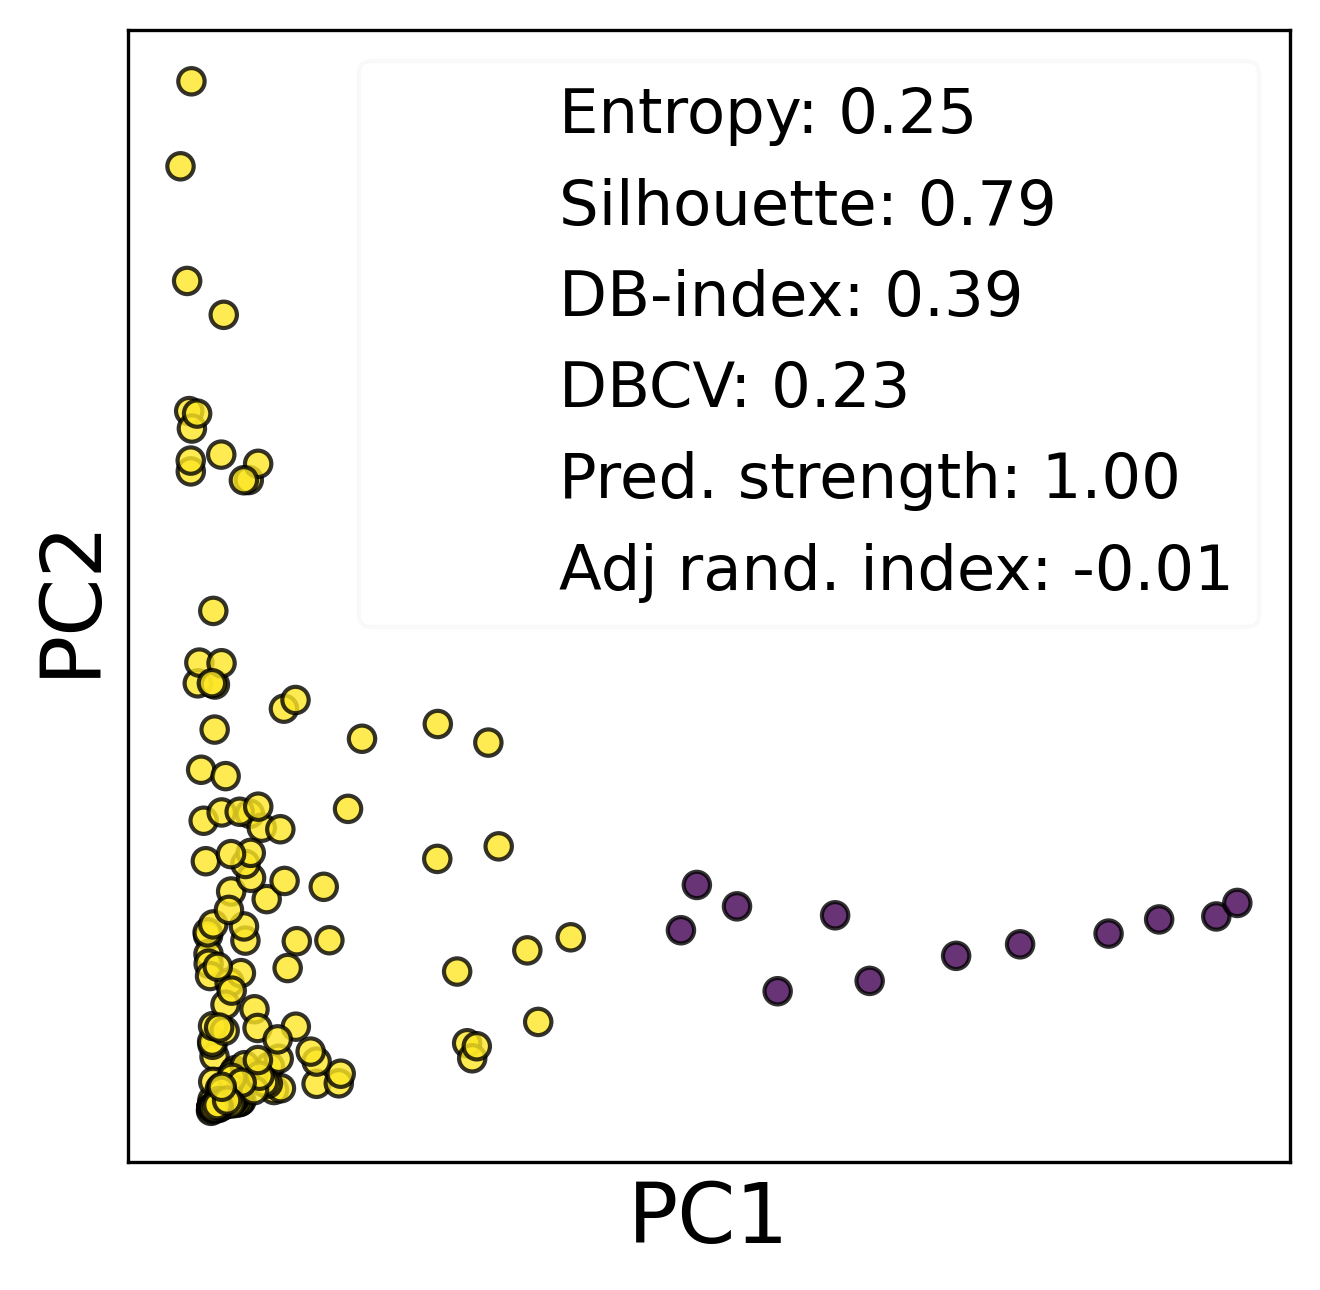

In [17]:
df_selected = PLSF_df_silh

idx = (df_selected['silh']).idxmax() 
best_clustering = df_selected.loc[idx]
y = best_clustering['labels']
df_mask = best_clustering['mask']
X_repr = best_clustering['representation']
X_tax = best_clustering['tax']
X_cl_method = best_clustering['cl_method']

X = data_pca['PLSF_g'][:,:2][df_mask]

ent, silh, dbind, dbcv, ps = np.array(best_clustering[['entropy', 'silh', 'dbind', 'dbcv', 'ps']].values, 
                                          dtype=np.float32).round(2)

RI = adjusted_rand_score(results_JS_PAM['PLSF_g']['labels'][df_mask], y)

plt.figure(figsize=(5,5), dpi=300)

plt.scatter(
            coord_to_pix(X[:,0]), 
            coord_to_pix(X[:,1]),
            c=y,
            edgecolors='black',
            s=40,
            alpha=0.8,
           )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])

handles, labels = plt.gca().get_legend_handles_labels()

text_handle = mlines.Line2D([], [], color='none', label='Entropy: {:.2f}'.format(ent))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Silhouette: {:.2f}'.format(silh))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DB-index: {:.2f}'.format(dbind))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DBCV: {:.2f}'.format(dbcv))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Pred. strength: {:.2f}'.format(ps))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Adj rand. index: {:.2f}'.format(RI))
handles.append(text_handle)

# Add the arbitrary information patch to the legend handles
legend = plt.legend(handles=handles, 
                    loc='best', 
                    fontsize=15, 
                    frameon=True, 
                    fancybox=True, 
                    framealpha=0.1)

X_REP = nice_repr[X_repr]
X_CL = nice_cl[X_cl_method]

plt.title(f'PLSF, tax: G, {X_REP}, {X_CL} \n Silhouette score & DB-index', fontsize=20)
plt.show()

## StCh

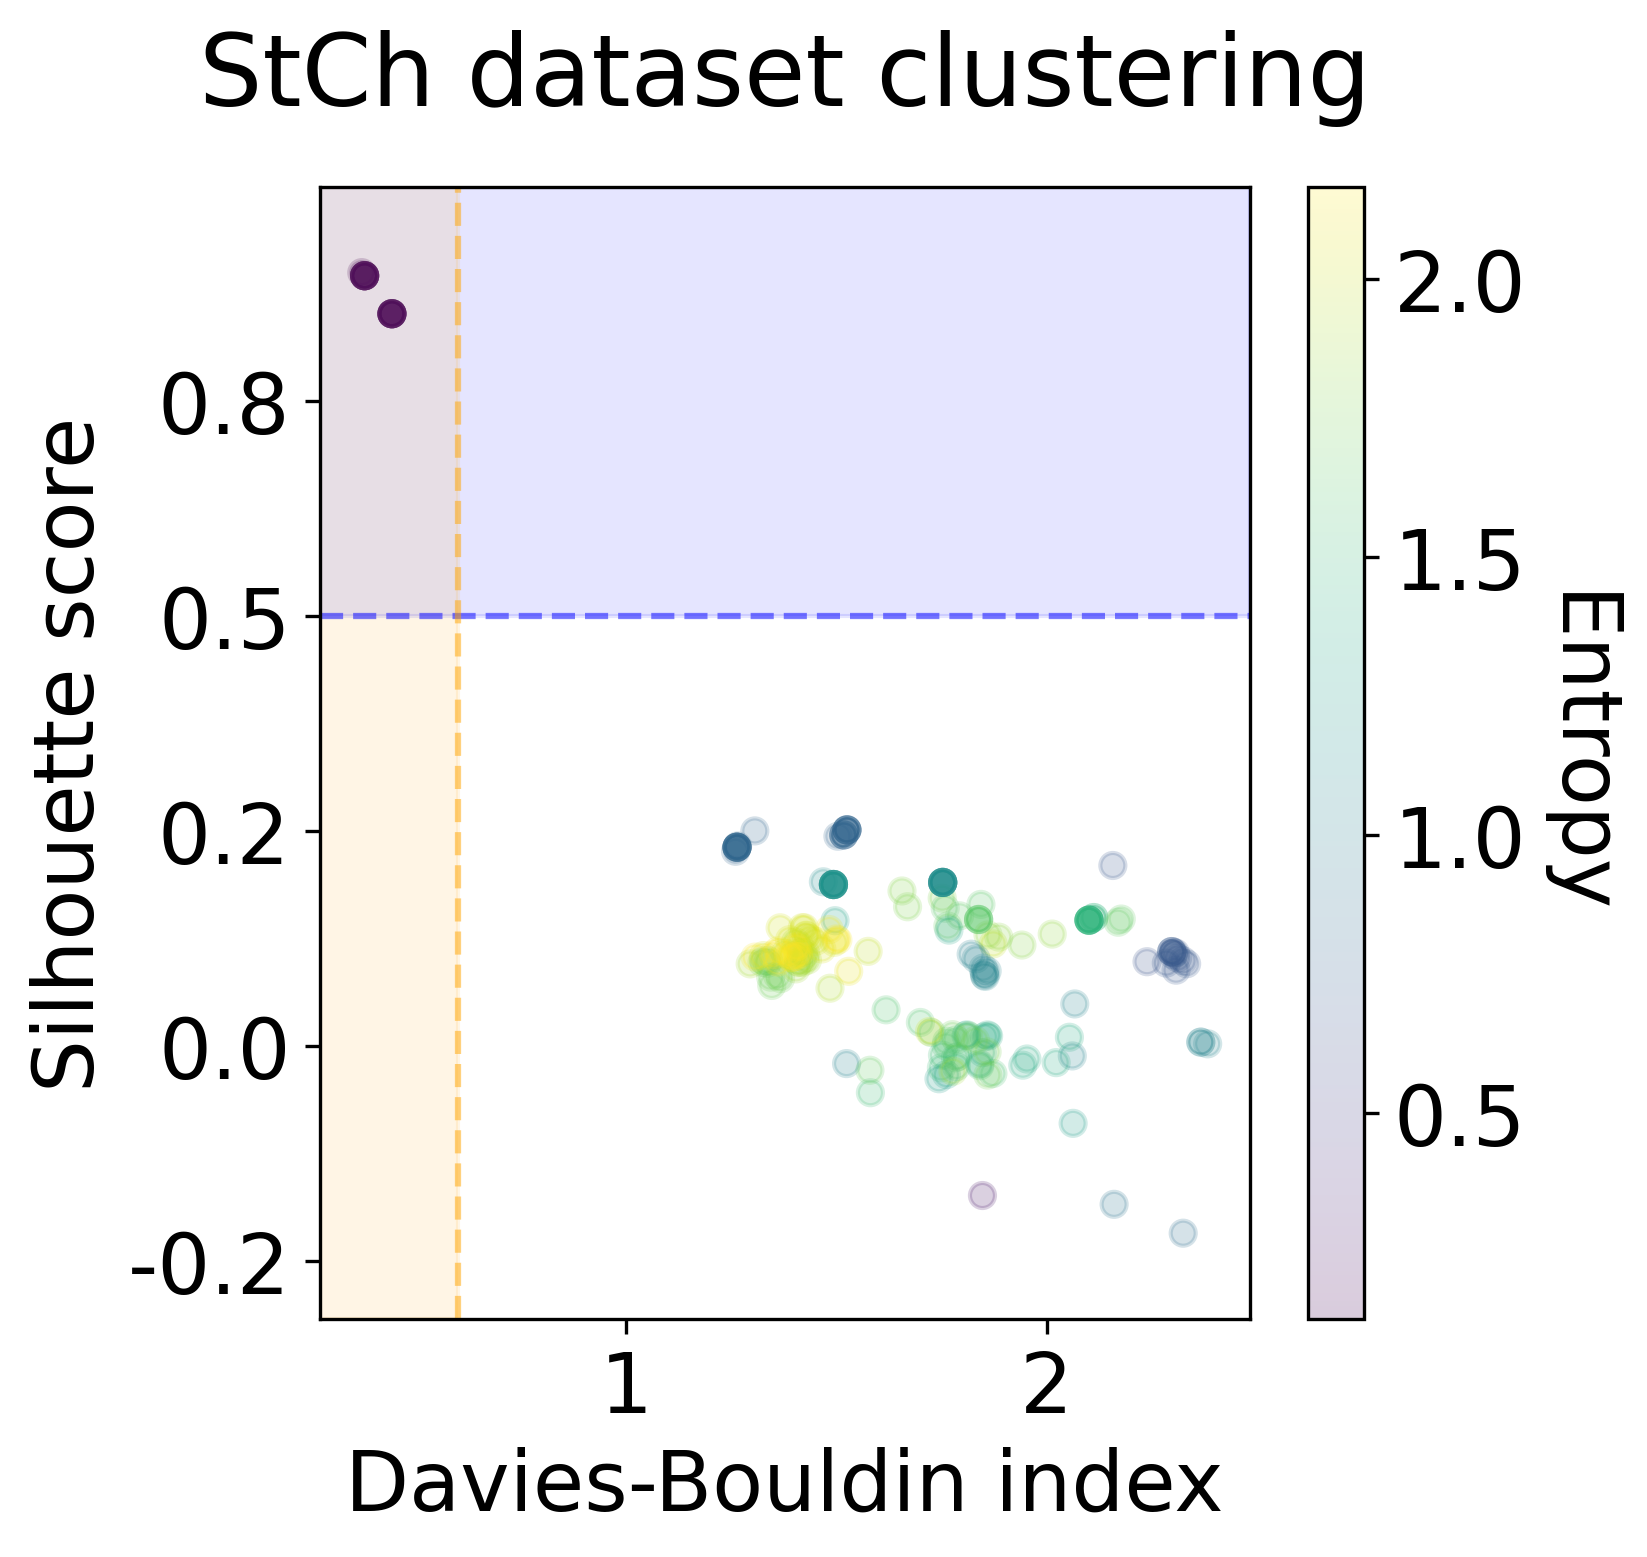

In [18]:
StCh_df = clustering_results_df_.query('dataset == "StCh"')

plot_clustering_scatter(StCh_df, 
                        x_metric_name='dbind',
                        y_metric_name='silh', 
                        coloring_metric_name='entropy', 
                        title='StCh dataset clustering',
                        y_threshold=SILHOUETTE_THRESH,
                        x_threshold=DBIND_THRESHOLD,
                        y_hue_line=1,
                        x_hue_line=0)


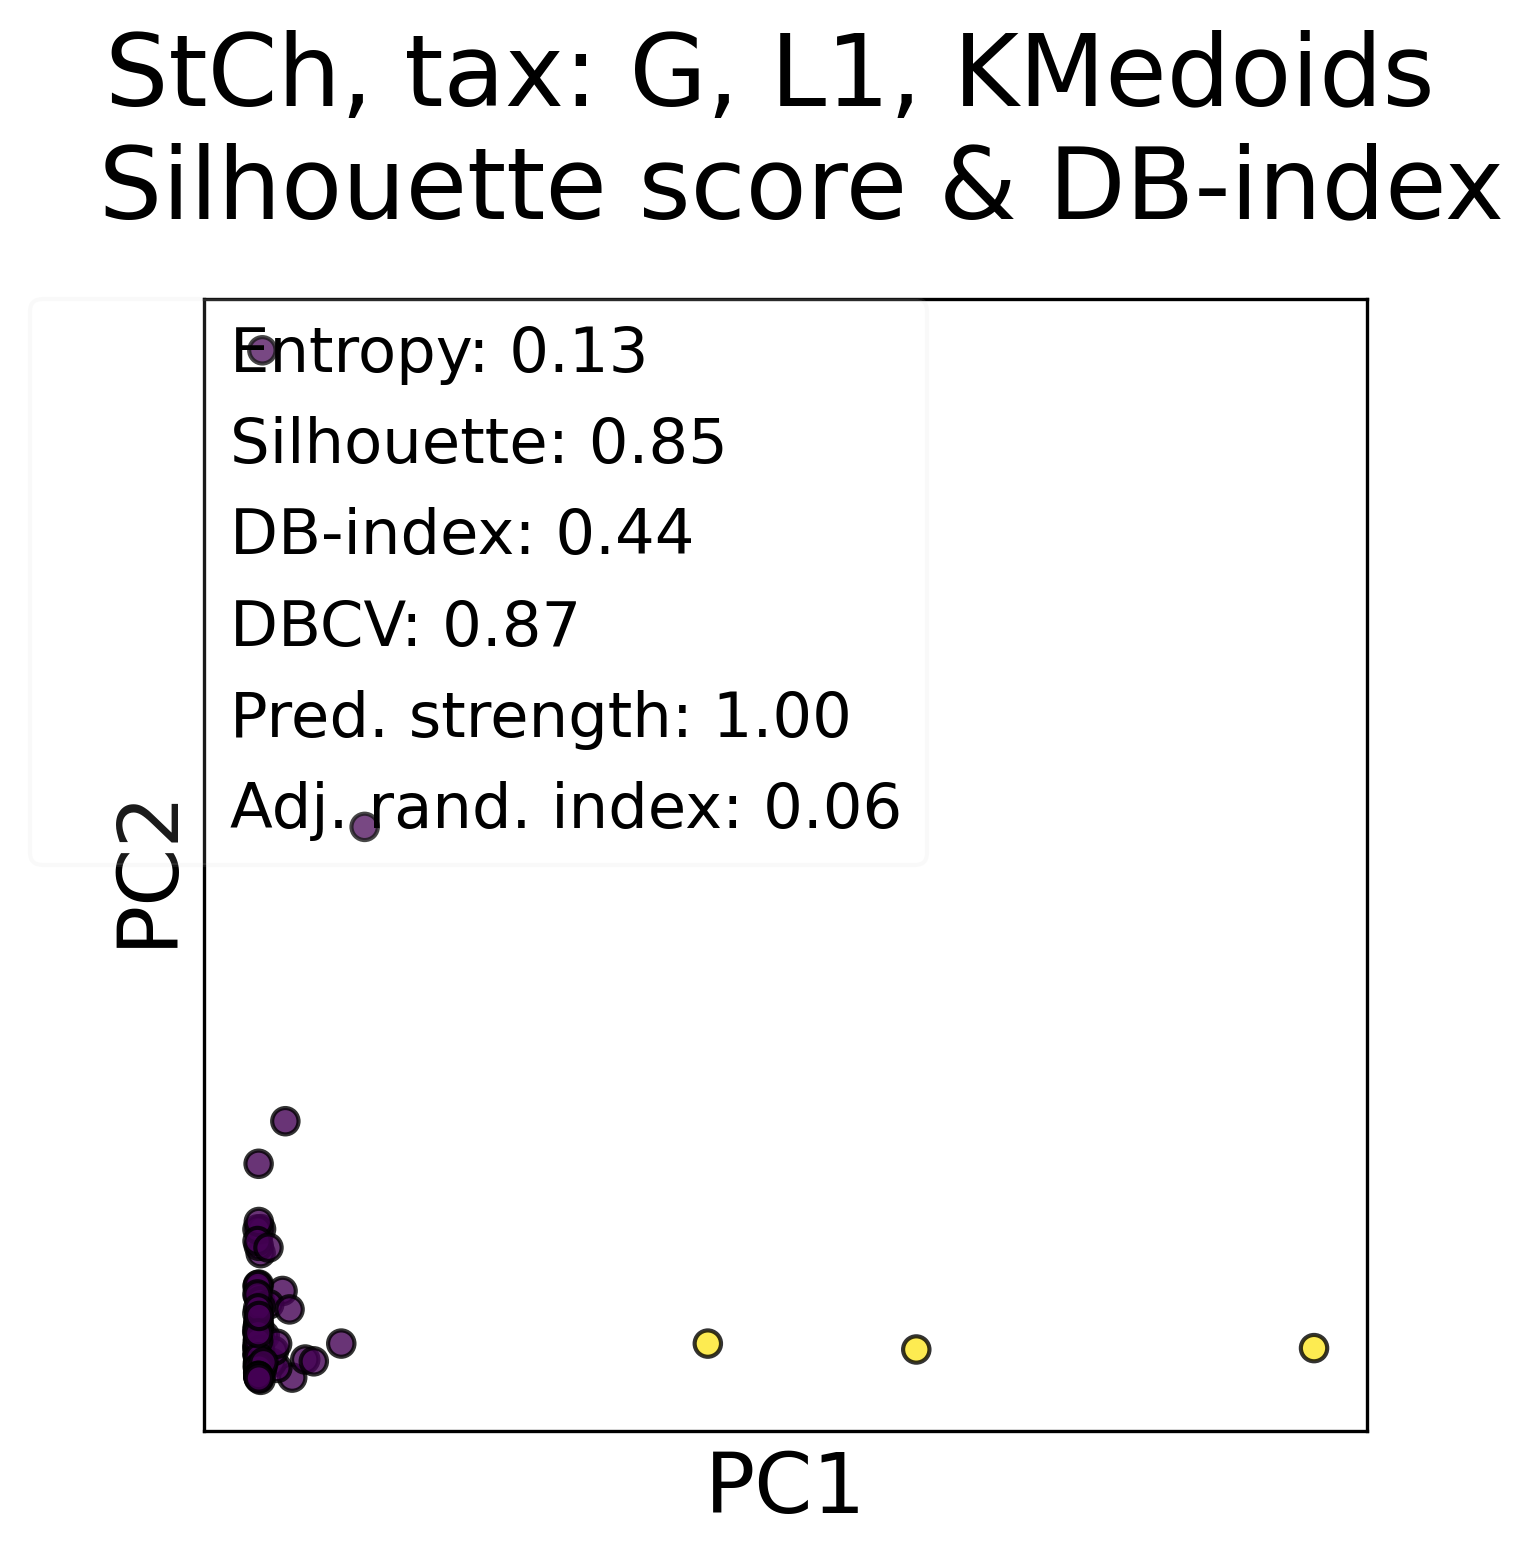

In [19]:
df = StCh_df
selection_mask_df = (df['silh'] >= SILHOUETTE_THRESH-5e-3) * (df['dbind'] <= DBIND_THRESHOLD+5e-3)
df_selected = df[selection_mask_df]
idx = df_selected['entropy'].idxmax()

best_clustering = df_selected.loc[idx]
y = best_clustering['labels']
df_mask = best_clustering['mask']
X_repr = best_clustering['representation']
X_tax = best_clustering['tax']
X_cl_method = best_clustering['cl_method']

X = data_pca['StCh_g'][:,:2][df_mask]

ent, silh, dbind, dbcv, ps = np.array(best_clustering[['entropy', 'silh', 'dbind', 'dbcv', 'ps']].values, 
                                          dtype=np.float32).round(2)

RI = adjusted_rand_score(results_JS_PAM['StCh_g']['labels'], y)

plt.figure(figsize=(5,5), dpi=300)

plt.scatter(
            coord_to_pix(X[:,0]), 
            coord_to_pix(X[:,1]),
            c=y,
            edgecolors='black',
            s=40,
            alpha=0.8,
           )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])

handles, labels = plt.gca().get_legend_handles_labels()

text_handle = mlines.Line2D([], [], color='none', label='Entropy: {:.2f}'.format(ent))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Silhouette: {:.2f}'.format(silh))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DB-index: {:.2f}'.format(dbind))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DBCV: {:.2f}'.format(dbcv))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Pred. strength: {:.2f}'.format(ps))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Adj. rand. index: {:.2f}'.format(RI))
handles.append(text_handle)

# Add the arbitrary information patch to the legend handles
legend = plt.legend(handles=handles, 
                    loc=(-0.15,0.5), 
                    fontsize=15, 
                    frameon=True, 
                    fancybox=True, 
                    framealpha=0.1)

plt.title(f'StCh, tax: G, {X_repr.upper()}, {X_cl_method} \n Silhouette score & DB-index')
plt.show()

##Buff

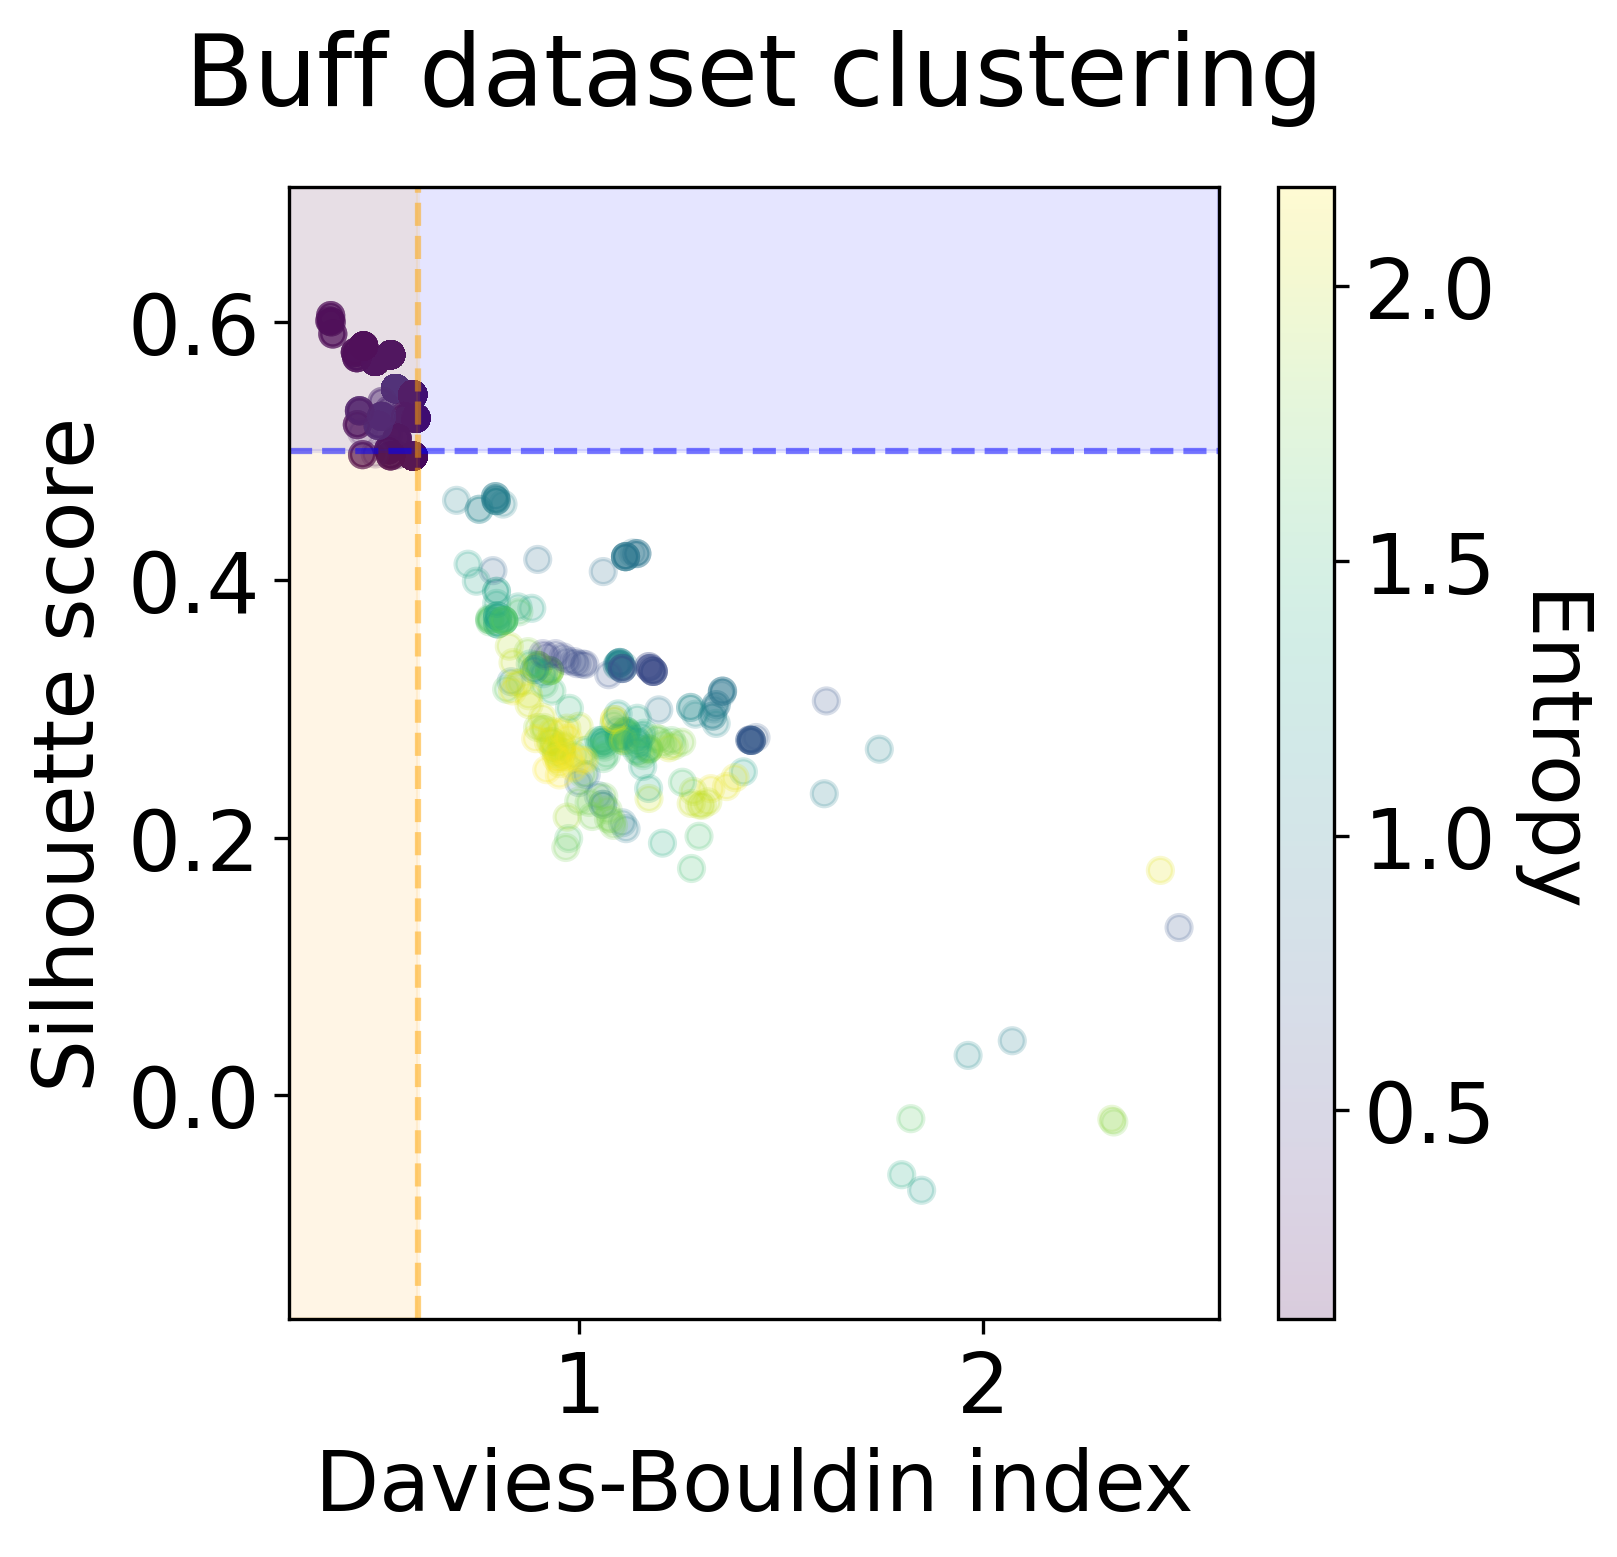

In [20]:
Buff_df = clustering_results_df_.query('dataset == "Buff"')

plot_clustering_scatter(Buff_df, 
                        x_metric_name='dbind',
                        y_metric_name='silh', 
                        coloring_metric_name='entropy', 
                        title='Buff dataset clustering',
                        y_threshold=SILHOUETTE_THRESH,
                        x_threshold=DBIND_THRESHOLD,
                        y_hue_line=1,
                        x_hue_line=0)

In [21]:
df = Buff_df
selection_mask_df = (df['silh'] >= SILHOUETTE_THRESH-5e-3) * (df['dbind'] <= DBIND_THRESHOLD+5e-3)
df_selected = df[selection_mask_df]
idx = df_selected['entropy'].idxmax()

best_clustering = df_selected.loc[idx]
y = best_clustering['labels']
df_mask = best_clustering['mask']
X_repr = best_clustering['representation']
X_tax = best_clustering['tax']
X_cl_method = best_clustering['cl_method']

X = data_pca['Buff_g'][:,:2][df_mask]

ent, silh, dbind, dbcv, ps = np.array(best_clustering[['entropy', 'silh', 'dbind', 'dbcv', 'ps']].values, 
                                          dtype=np.float32).round(2)

RI = adjusted_rand_score(results_JS_PAM['Buff_g']['labels'], y)

plt.figure(figsize=(5,5), dpi=300)

plt.scatter(
            coord_to_pix(X[:,0]), 
            coord_to_pix(X[:,1]),
            c=y,
            edgecolors='black',
            s=40,
            alpha=0.8,
           )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])

handles, labels = plt.gca().get_legend_handles_labels()

text_handle = mlines.Line2D([], [], color='none', label='Entropy: {:.2f}'.format(ent))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Silhouette: {:.2f}'.format(silh))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DB-index: {:.2f}'.format(dbind))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DBCV: {:.2f}'.format(dbcv))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Pred. strength: {:.2f}'.format(ps))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Adj. rand. index: {:.2f}'.format(RI))
handles.append(text_handle)

# Add the arbitrary information patch to the legend handles
legend = plt.legend(handles=handles, 
                    loc=(-0.15,0.5), 
                    fontsize=15, 
                    frameon=True, 
                    fancybox=True, 
                    framealpha=0.1)

plt.title(f'Buff, tax: G, {X_repr.upper()}, {X_cl_method} \n Silhouette score & DB-index')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [160, 153]

## Champ

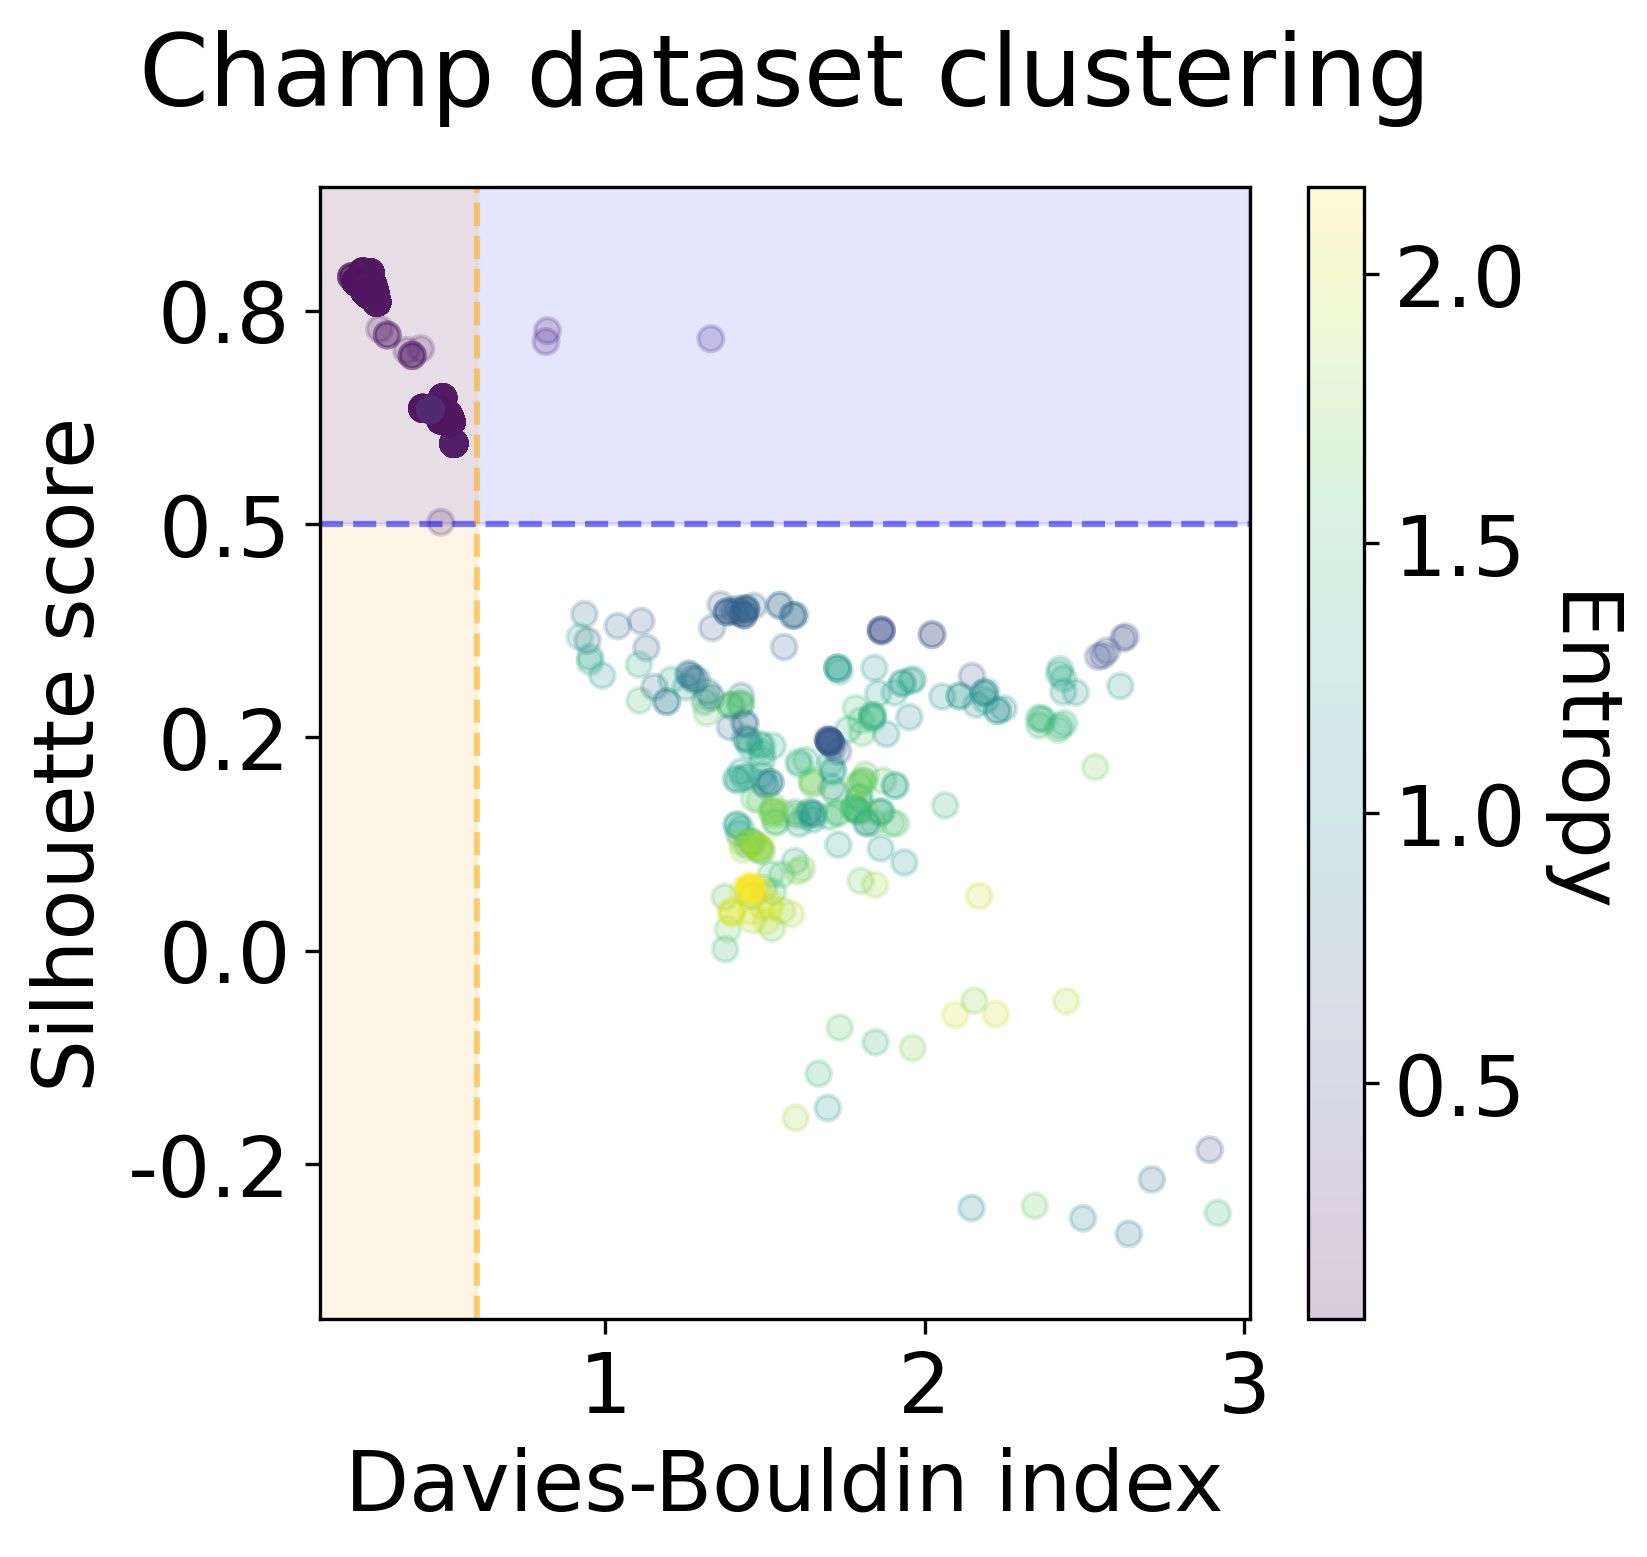

In [22]:
Champ_df = clustering_results_df_.query('dataset == "Champ"')

plot_clustering_scatter(Champ_df, 
                        x_metric_name='dbind',
                        y_metric_name='silh', 
                        coloring_metric_name='entropy', 
                        title='Champ dataset clustering',
                        y_threshold=SILHOUETTE_THRESH,
                        x_threshold=DBIND_THRESHOLD,
                        y_hue_line=1,
                        x_hue_line=0)

In [23]:
df_selected = Champ_df
idx = (df_selected['silh']).idxmax() 

best_clustering = df_selected.loc[idx]
y = best_clustering['labels']
df_mask = best_clustering['mask']
X_repr = best_clustering['representation']
X_tax = best_clustering['tax']
X_cl_method = best_clustering['cl_method']

X = data_pca['Champ_g'][:,:2][df_mask]

ent, silh, dbind, dbcv, ps = np.array(best_clustering[['entropy', 'silh', 'dbind', 'dbcv', 'ps']].values, 
                                          dtype=np.float32).round(2)



RI = adjusted_rand_score(results_JS_PAM['Champ_g']['labels'], y)

plt.figure(figsize=(5,5), dpi=300)

plt.scatter(
            coord_to_pix(X[:,0]), 
            coord_to_pix(X[:,1]),
            c=y,
            edgecolors='black',
            s=40,
            alpha=0.8,
           )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])

handles, labels = plt.gca().get_legend_handles_labels()

text_handle = mlines.Line2D([], [], color='none', label='Entropy: {:.2f}'.format(ent))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Silhouette: {:.2f}'.format(silh))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DB-index: {:.2f}'.format(dbind))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DBCV: {:.2f}'.format(dbcv))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Pred. strength: {:.2f}'.format(ps))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Adj. rand. index: {:.2f}'.format(RI))
handles.append(text_handle)

# Add the arbitrary information patch to the legend handles
legend = plt.legend(handles=handles, 
                    loc=(-0.15,0.5), 
                    fontsize=15, 
                    frameon=True, 
                    fancybox=True, 
                    framealpha=0.1)

plt.title(f'Champ, tax: G, {X_repr.upper()}, {X_cl_method} \n Silhouette score & DB-index')
plt.show()

KeyError: 'Champ_g'

## Conest

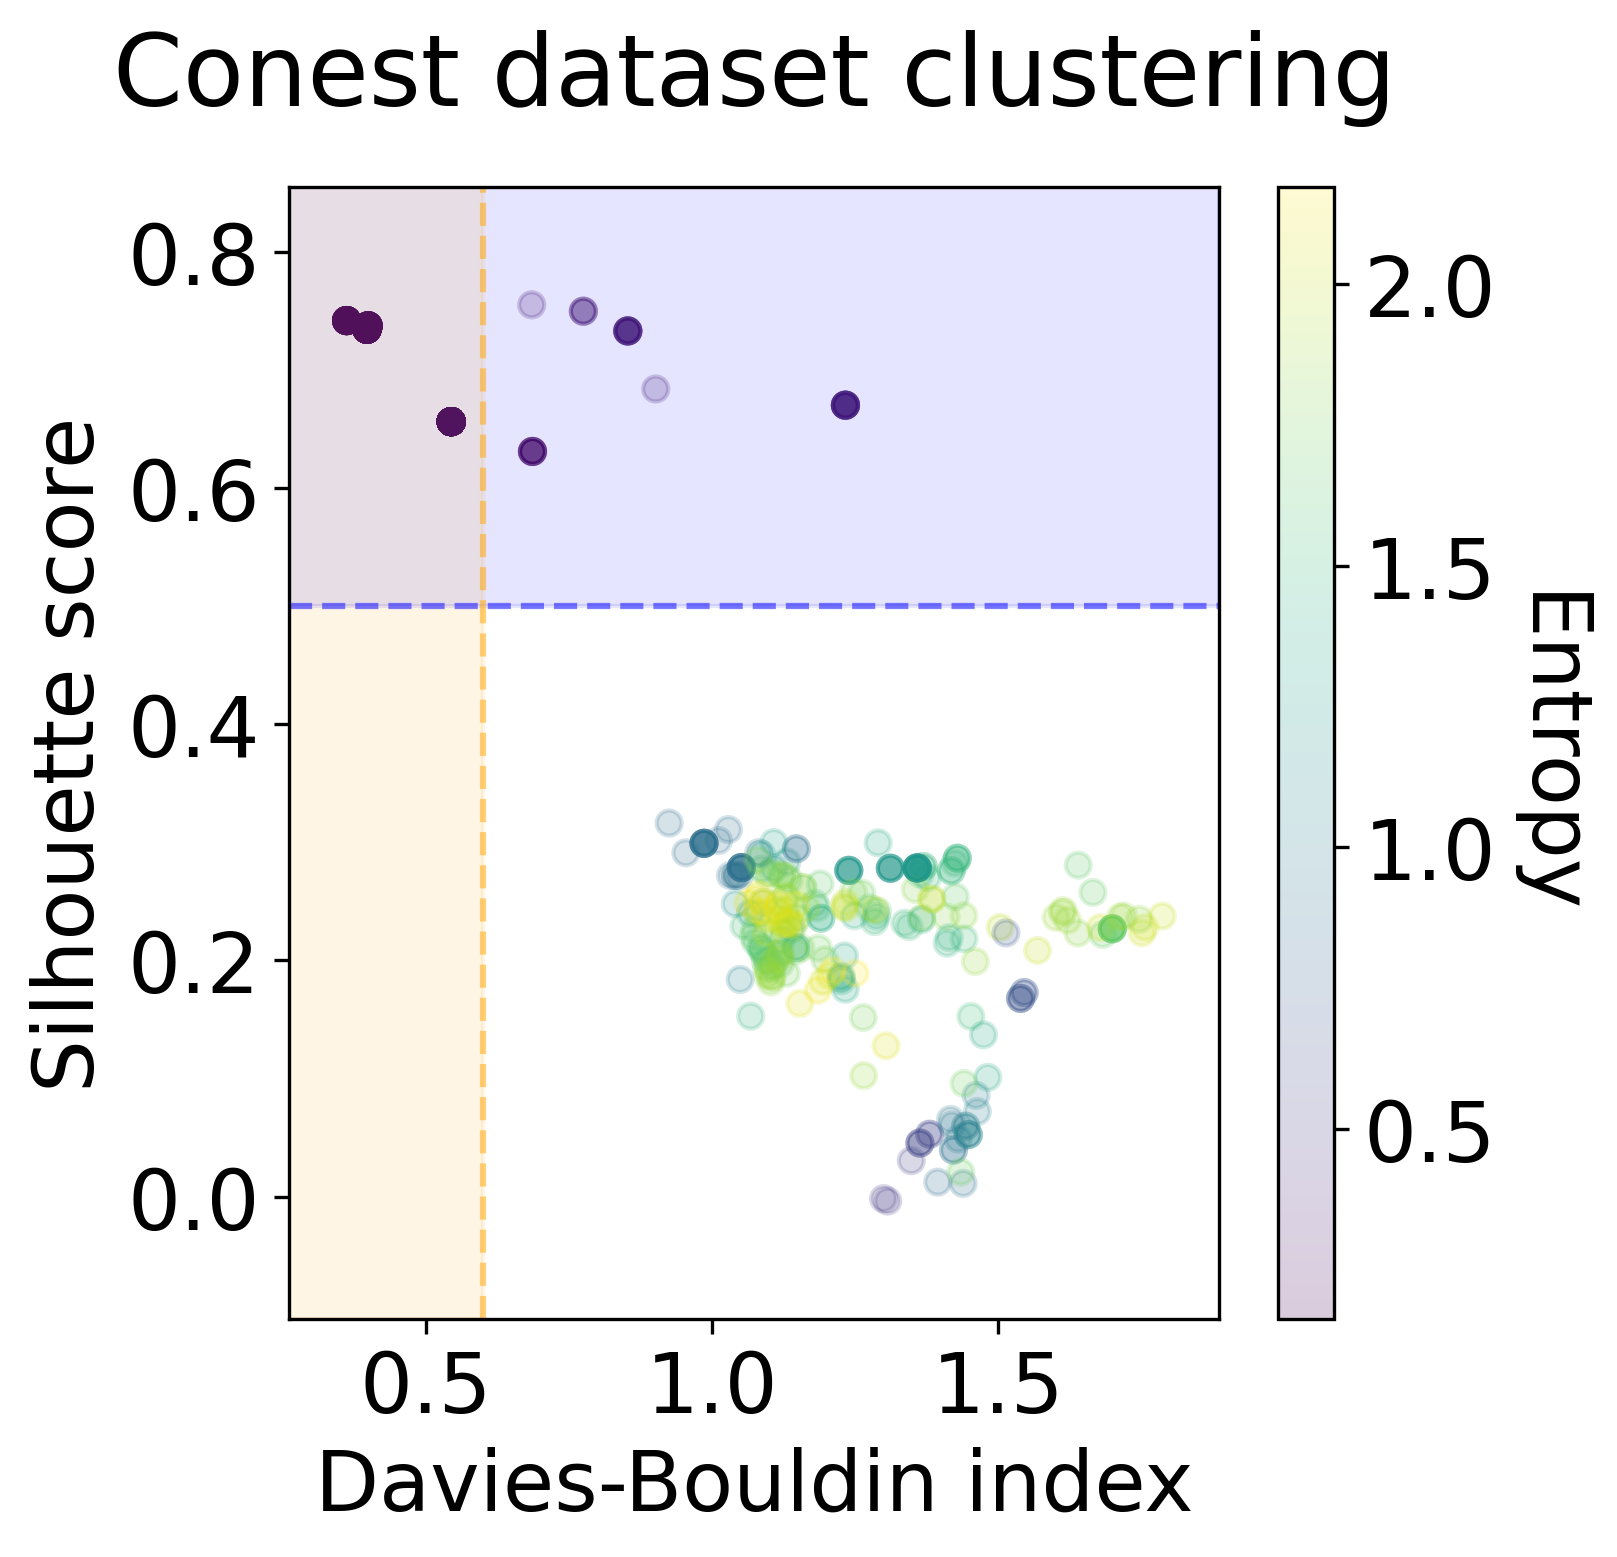

In [24]:
Conest_df = clustering_results_df_.query('dataset == "Conest"')

plot_clustering_scatter(Conest_df, 
                        x_metric_name='dbind',
                        y_metric_name='silh', 
                        coloring_metric_name='entropy', 
                        title='Conest dataset clustering',
                        y_threshold=SILHOUETTE_THRESH,
                        x_threshold=DBIND_THRESHOLD,
                        y_hue_line=1,
                        x_hue_line=0)

In [25]:
df_selected = Conest_df
idx = (df_selected['silh']).idxmax() 

best_clustering = df_selected.loc[idx]
y = best_clustering['labels']
df_mask = best_clustering['mask']
X_repr = best_clustering['representation']
X_tax = best_clustering['tax']
X_cl_method = best_clustering['cl_method']

X = data_pca['Conest_g'][:,:2][df_mask]

ent, silh, dbind, dbcv, ps = np.array(best_clustering[['entropy', 'silh', 'dbind', 'dbcv', 'ps']].values, 
                                          dtype=np.float32).round(2)



RI = adjusted_rand_score(results_JS_PAM['Conest_g']['labels'], y)

plt.figure(figsize=(5,5), dpi=300)

plt.scatter(
            coord_to_pix(X[:,0]), 
            coord_to_pix(X[:,1]),
            c=y,
            edgecolors='black',
            s=40,
            alpha=0.8,
           )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])

handles, labels = plt.gca().get_legend_handles_labels()

text_handle = mlines.Line2D([], [], color='none', label='Entropy: {:.2f}'.format(ent))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Silhouette: {:.2f}'.format(silh))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DB-index: {:.2f}'.format(dbind))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DBCV: {:.2f}'.format(dbcv))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Pred. strength: {:.2f}'.format(ps))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Adj. rand. index: {:.2f}'.format(RI))
handles.append(text_handle)

# Add the arbitrary information patch to the legend handles
legend = plt.legend(handles=handles, 
                    loc=(-0.15,0.5), 
                    fontsize=15, 
                    frameon=True, 
                    fancybox=True, 
                    framealpha=0.1)

plt.title(f'Conest, tax: G, {X_repr.upper()}, {X_cl_method} \n Silhouette score & DB-index')
plt.show()

KeyError: 'Conest_g'

## rotor

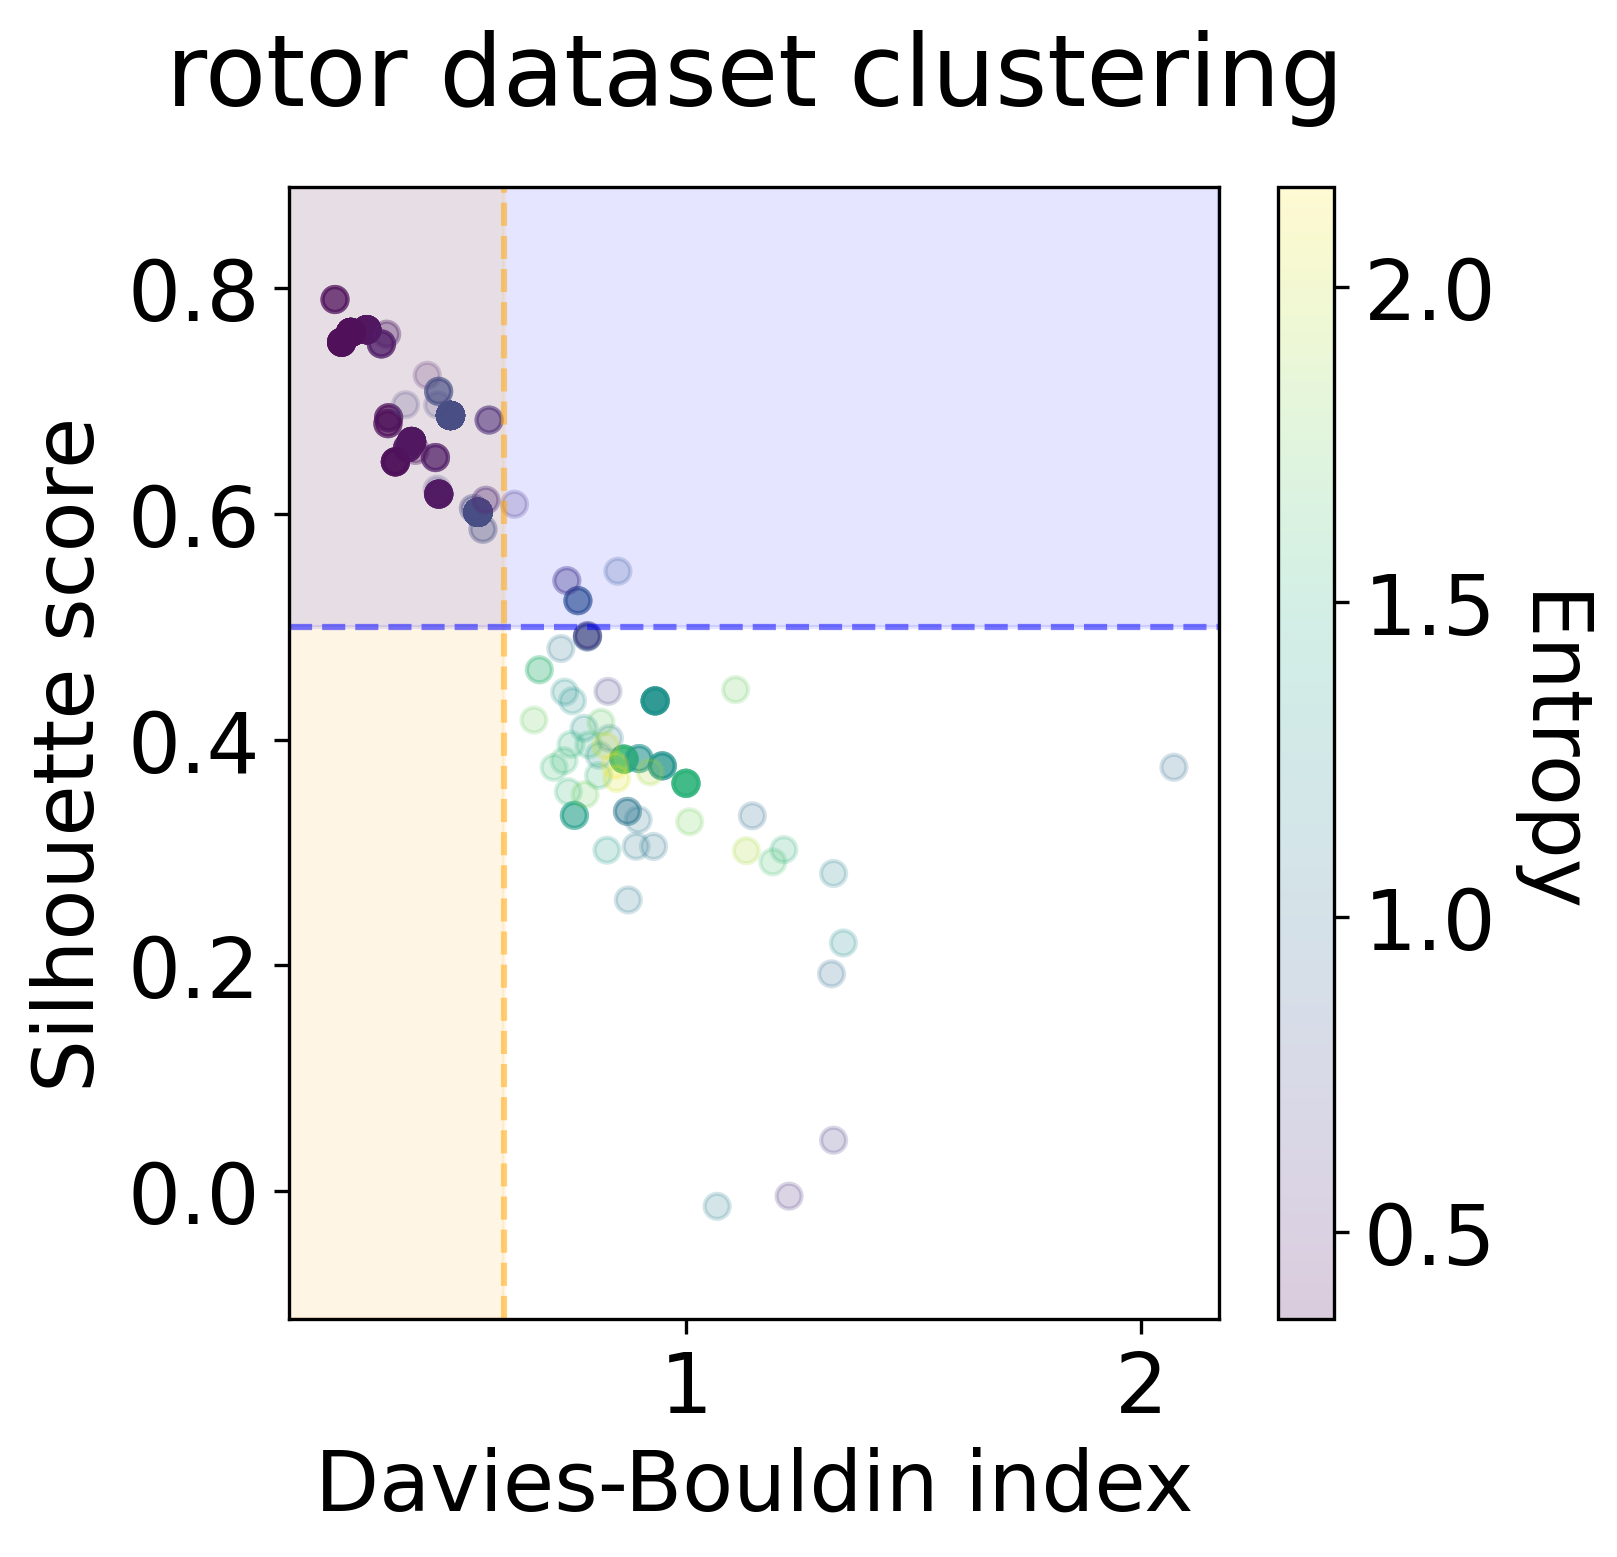

In [26]:
rotor_df = clustering_results_df_.query('dataset == "rotor"')

plot_clustering_scatter(rotor_df, 
                        x_metric_name='dbind',
                        y_metric_name='silh', 
                        coloring_metric_name='entropy', 
                        title='rotor dataset clustering',
                        y_threshold=SILHOUETTE_THRESH,
                        x_threshold=DBIND_THRESHOLD,
                        y_hue_line=1,
                        x_hue_line=0)

In [27]:
df_selected = rotor_df
idx = (df_selected['silh']).idxmax() 

best_clustering = df_selected.loc[idx]
y = best_clustering['labels']
df_mask = best_clustering['mask']
X_repr = best_clustering['representation']
X_tax = best_clustering['tax']
X_cl_method = best_clustering['cl_method']

X = data_pca['rotor_g'][:,:2][df_mask]

ent, silh, dbind, dbcv, ps = np.array(best_clustering[['entropy', 'silh', 'dbind', 'dbcv', 'ps']].values, 
                                          dtype=np.float32).round(2)



RI = adjusted_rand_score(results_JS_PAM['rotor_g']['labels'], y)

plt.figure(figsize=(5,5), dpi=300)

plt.scatter(
            coord_to_pix(X[:,0]), 
            coord_to_pix(X[:,1]),
            c=y,
            edgecolors='black',
            s=40,
            alpha=0.8,
           )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])

handles, labels = plt.gca().get_legend_handles_labels()

text_handle = mlines.Line2D([], [], color='none', label='Entropy: {:.2f}'.format(ent))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Silhouette: {:.2f}'.format(silh))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DB-index: {:.2f}'.format(dbind))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DBCV: {:.2f}'.format(dbcv))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Pred. strength: {:.2f}'.format(ps))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Adj. rand. index: {:.2f}'.format(RI))
handles.append(text_handle)

# Add the arbitrary information patch to the legend handles
legend = plt.legend(handles=handles, 
                    loc=(-0.15,0.5), 
                    fontsize=15, 
                    frameon=True, 
                    fancybox=True, 
                    framealpha=0.1)

plt.title(f'rotor, tax: G, {X_repr.upper()}, {X_cl_method} \n Silhouette score & DB-index')
plt.show()

KeyError: 'rotor_g'

## otherLake

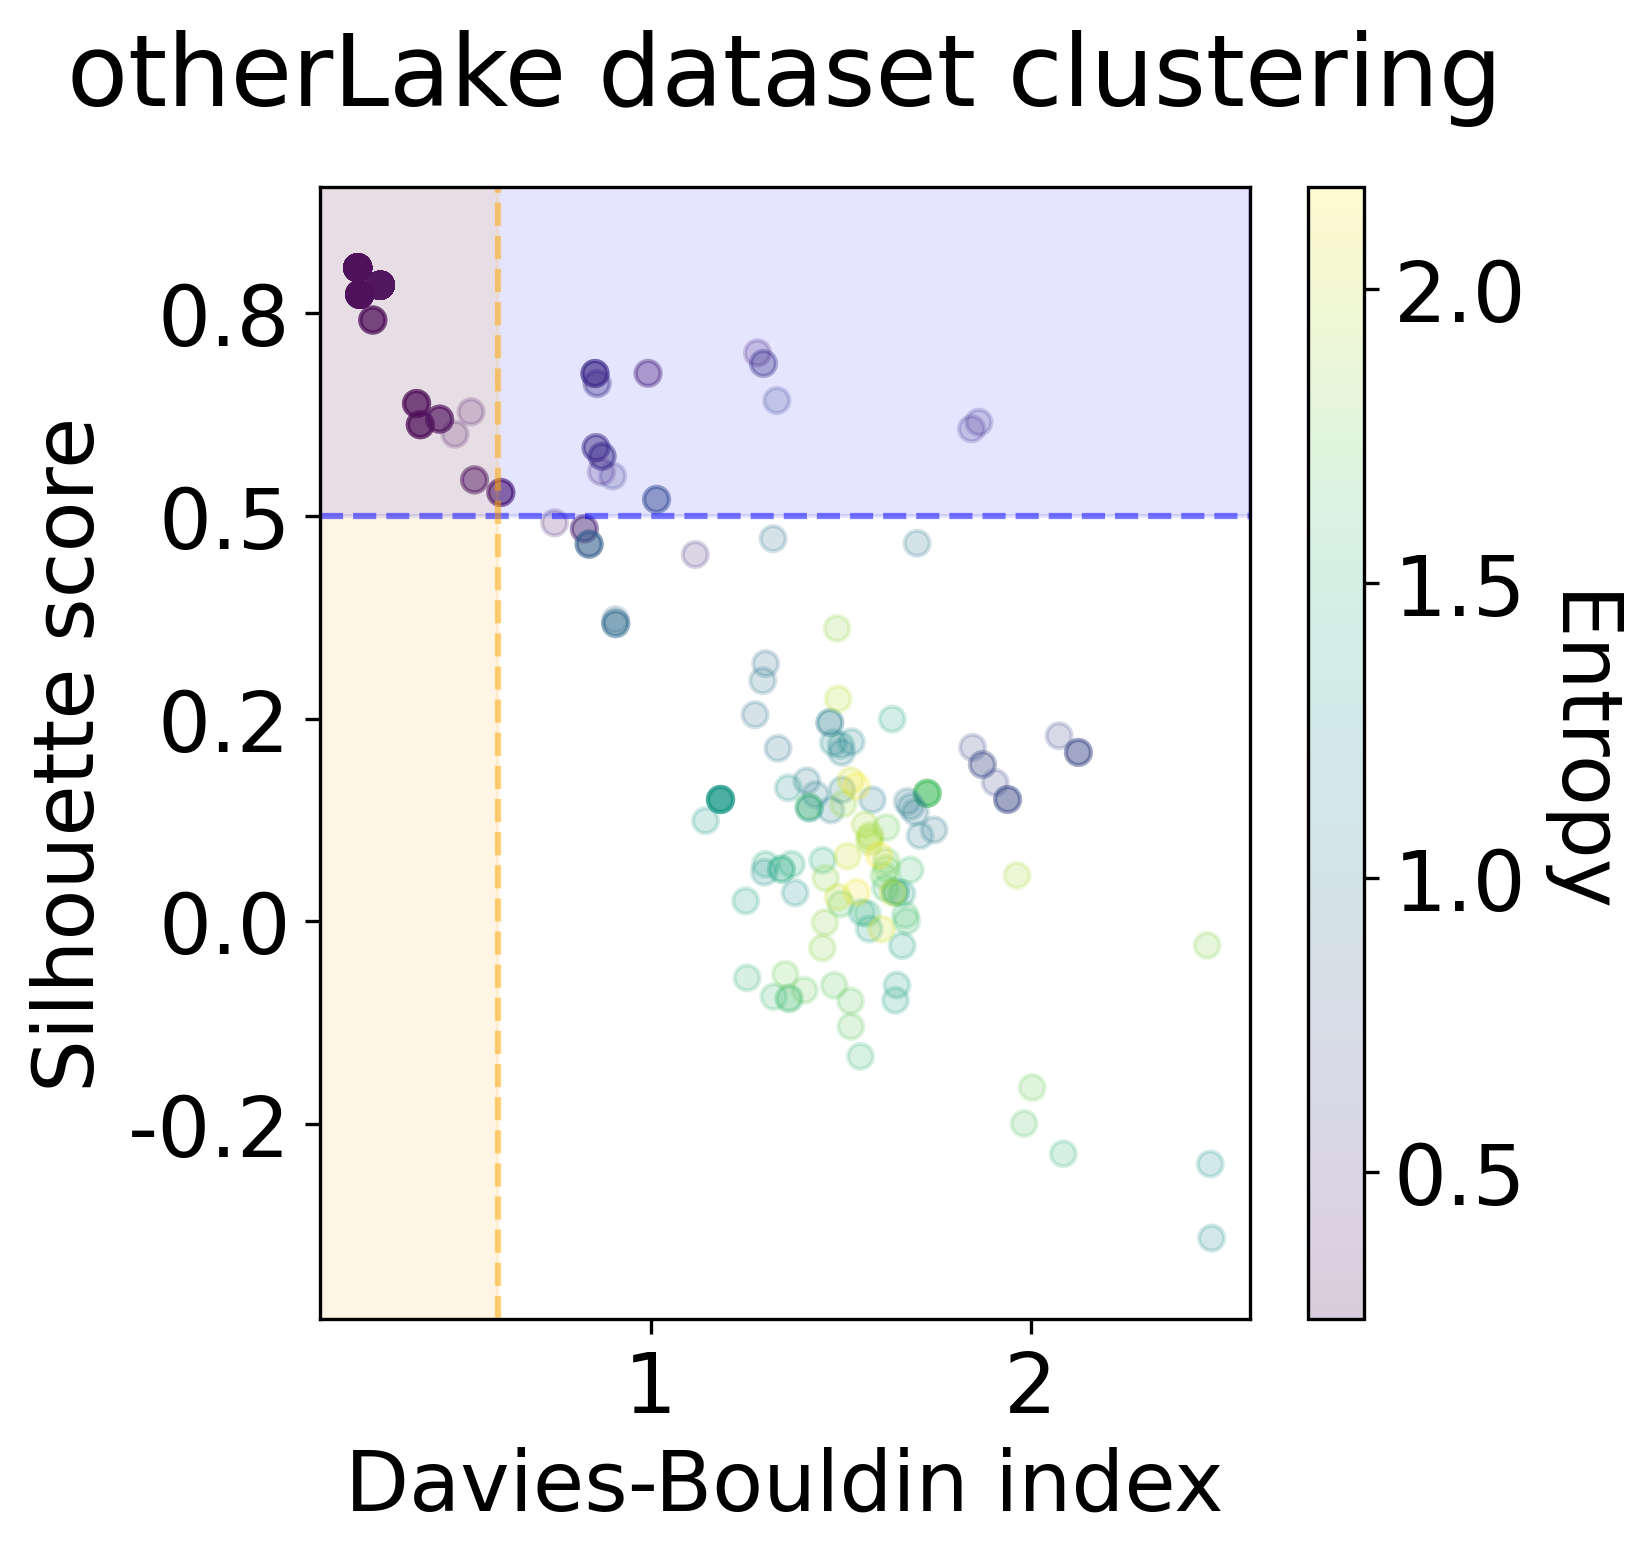

In [28]:
otherLake_df = clustering_results_df_.query('dataset == "otherLake"')

plot_clustering_scatter(otherLake_df, 
                        x_metric_name='dbind',
                        y_metric_name='silh', 
                        coloring_metric_name='entropy', 
                        title='otherLake dataset clustering',
                        y_threshold=SILHOUETTE_THRESH,
                        x_threshold=DBIND_THRESHOLD,
                        y_hue_line=1,
                        x_hue_line=0)

In [29]:
df_selected = otherLake_df
idx = (df_selected['silh']).idxmax() 

best_clustering = df_selected.loc[idx]
y = best_clustering['labels']
df_mask = best_clustering['mask']
X_repr = best_clustering['representation']
X_tax = best_clustering['tax']
X_cl_method = best_clustering['cl_method']

X = data_pca['otherLake_g'][:,:2][df_mask]

ent, silh, dbind, dbcv, ps = np.array(best_clustering[['entropy', 'silh', 'dbind', 'dbcv', 'ps']].values, 
                                          dtype=np.float32).round(2)



RI = adjusted_rand_score(results_JS_PAM['otherLake_g']['labels'], y)

plt.figure(figsize=(5,5), dpi=300)

plt.scatter(
            coord_to_pix(X[:,0]), 
            coord_to_pix(X[:,1]),
            c=y,
            edgecolors='black',
            s=40,
            alpha=0.8,
           )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])

handles, labels = plt.gca().get_legend_handles_labels()

text_handle = mlines.Line2D([], [], color='none', label='Entropy: {:.2f}'.format(ent))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Silhouette: {:.2f}'.format(silh))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DB-index: {:.2f}'.format(dbind))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DBCV: {:.2f}'.format(dbcv))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Pred. strength: {:.2f}'.format(ps))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Adj. rand. index: {:.2f}'.format(RI))
handles.append(text_handle)

# Add the arbitrary information patch to the legend handles
legend = plt.legend(handles=handles, 
                    loc=(-0.15,0.5), 
                    fontsize=15, 
                    frameon=True, 
                    fancybox=True, 
                    framealpha=0.1)

plt.title(f'otherLake, tax: G, {X_repr.upper()}, {X_cl_method} \n Silhouette score & DB-index')
plt.show()

KeyError: 'otherLake_g'

# DBCV index and Prediction Strength

## PLSF

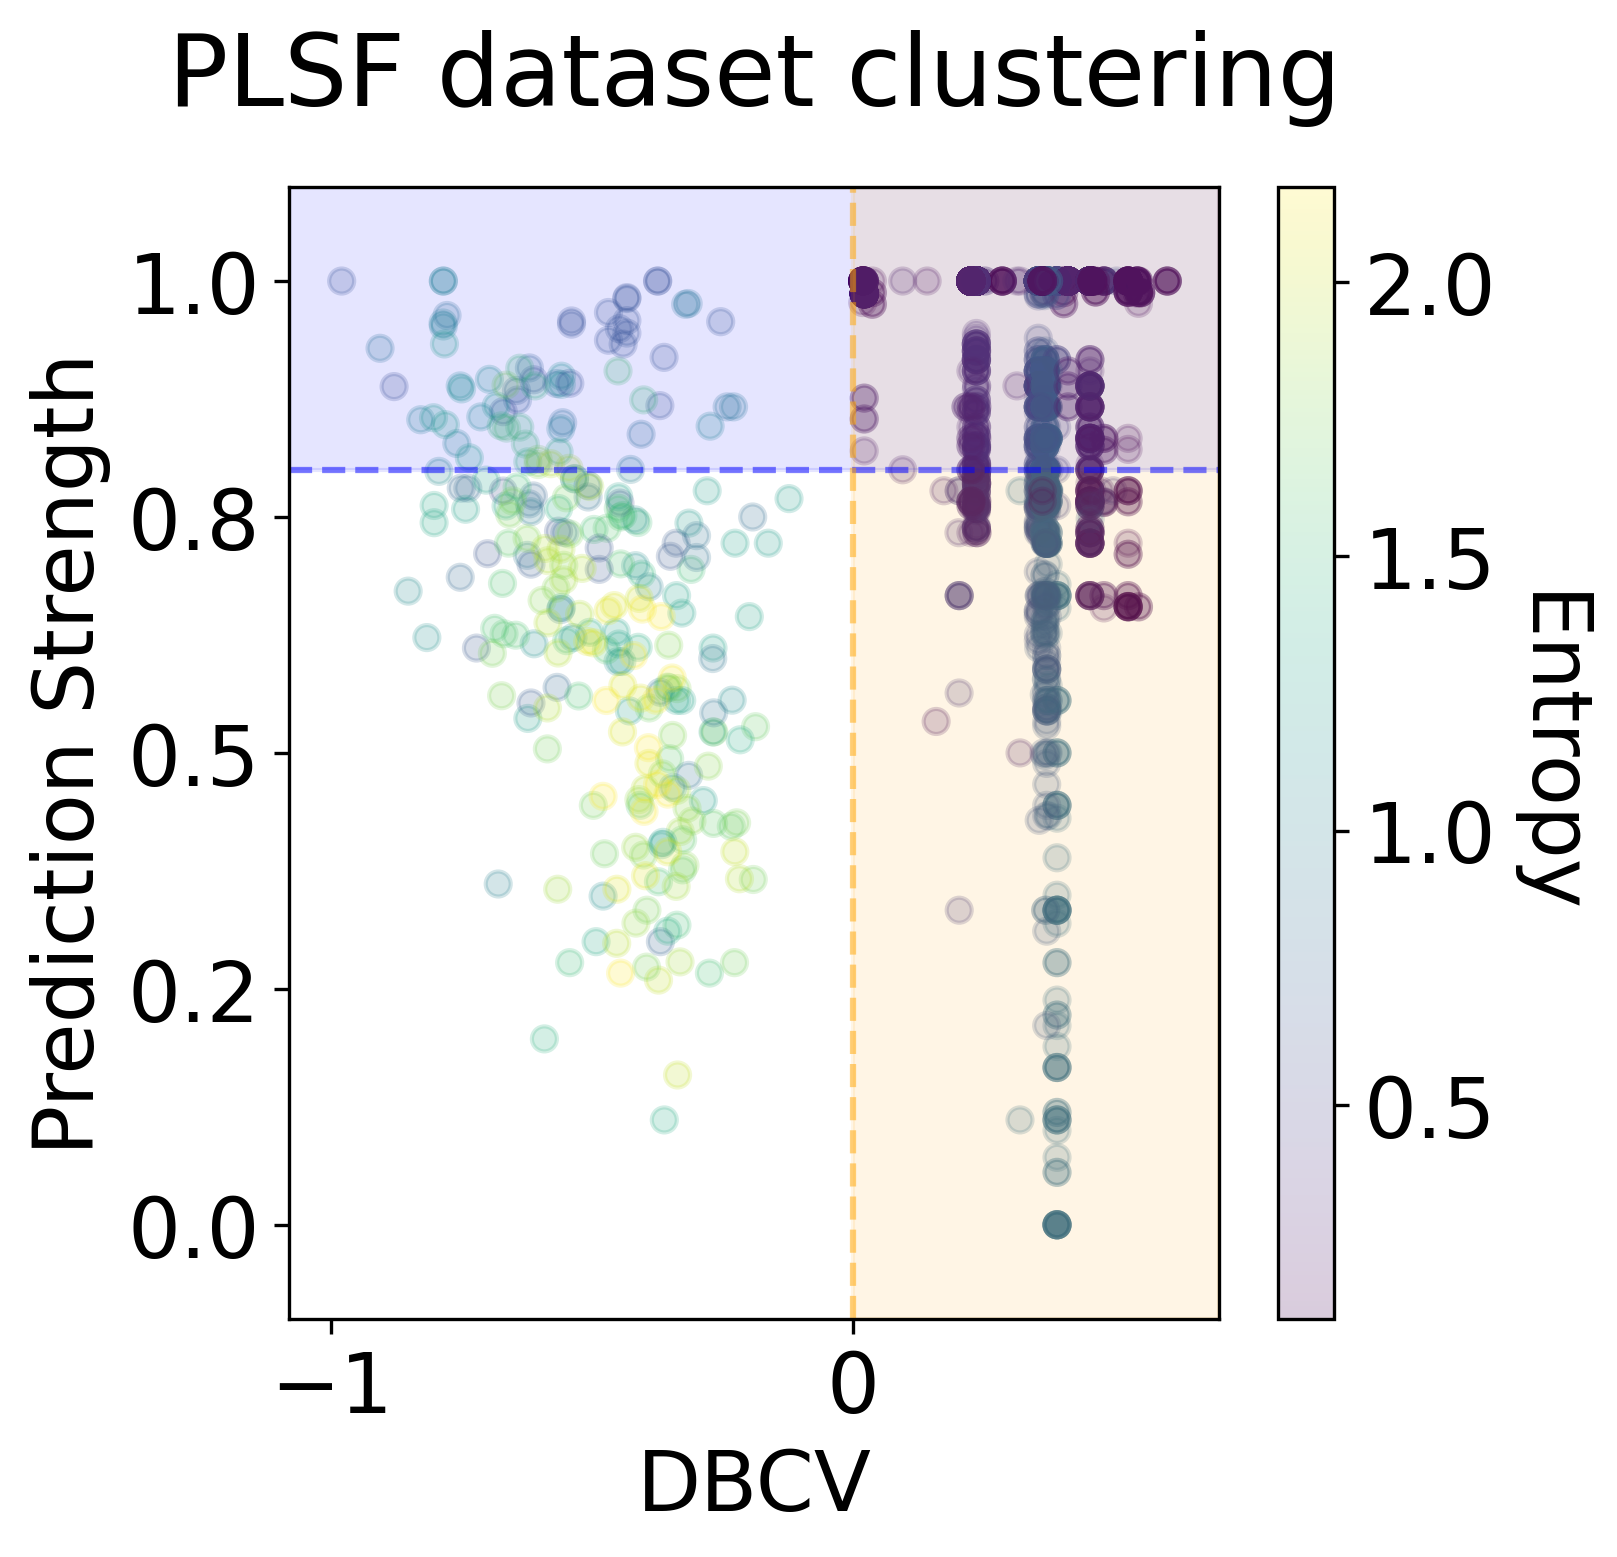

In [30]:
PLSF_df = clustering_results_df_.query('dataset == "PLSF"')

plot_clustering_scatter(PLSF_df, 
                        x_metric_name='dbcv',
                        y_metric_name='ps', 
                        coloring_metric_name='entropy', 
                        title='PLSF dataset clustering',
                        y_threshold=PS_THRESHOLD,
                        x_threshold=DBCV_THRESHOLD,
                        y_hue_line=1.2,
                        x_hue_line=1
                        )

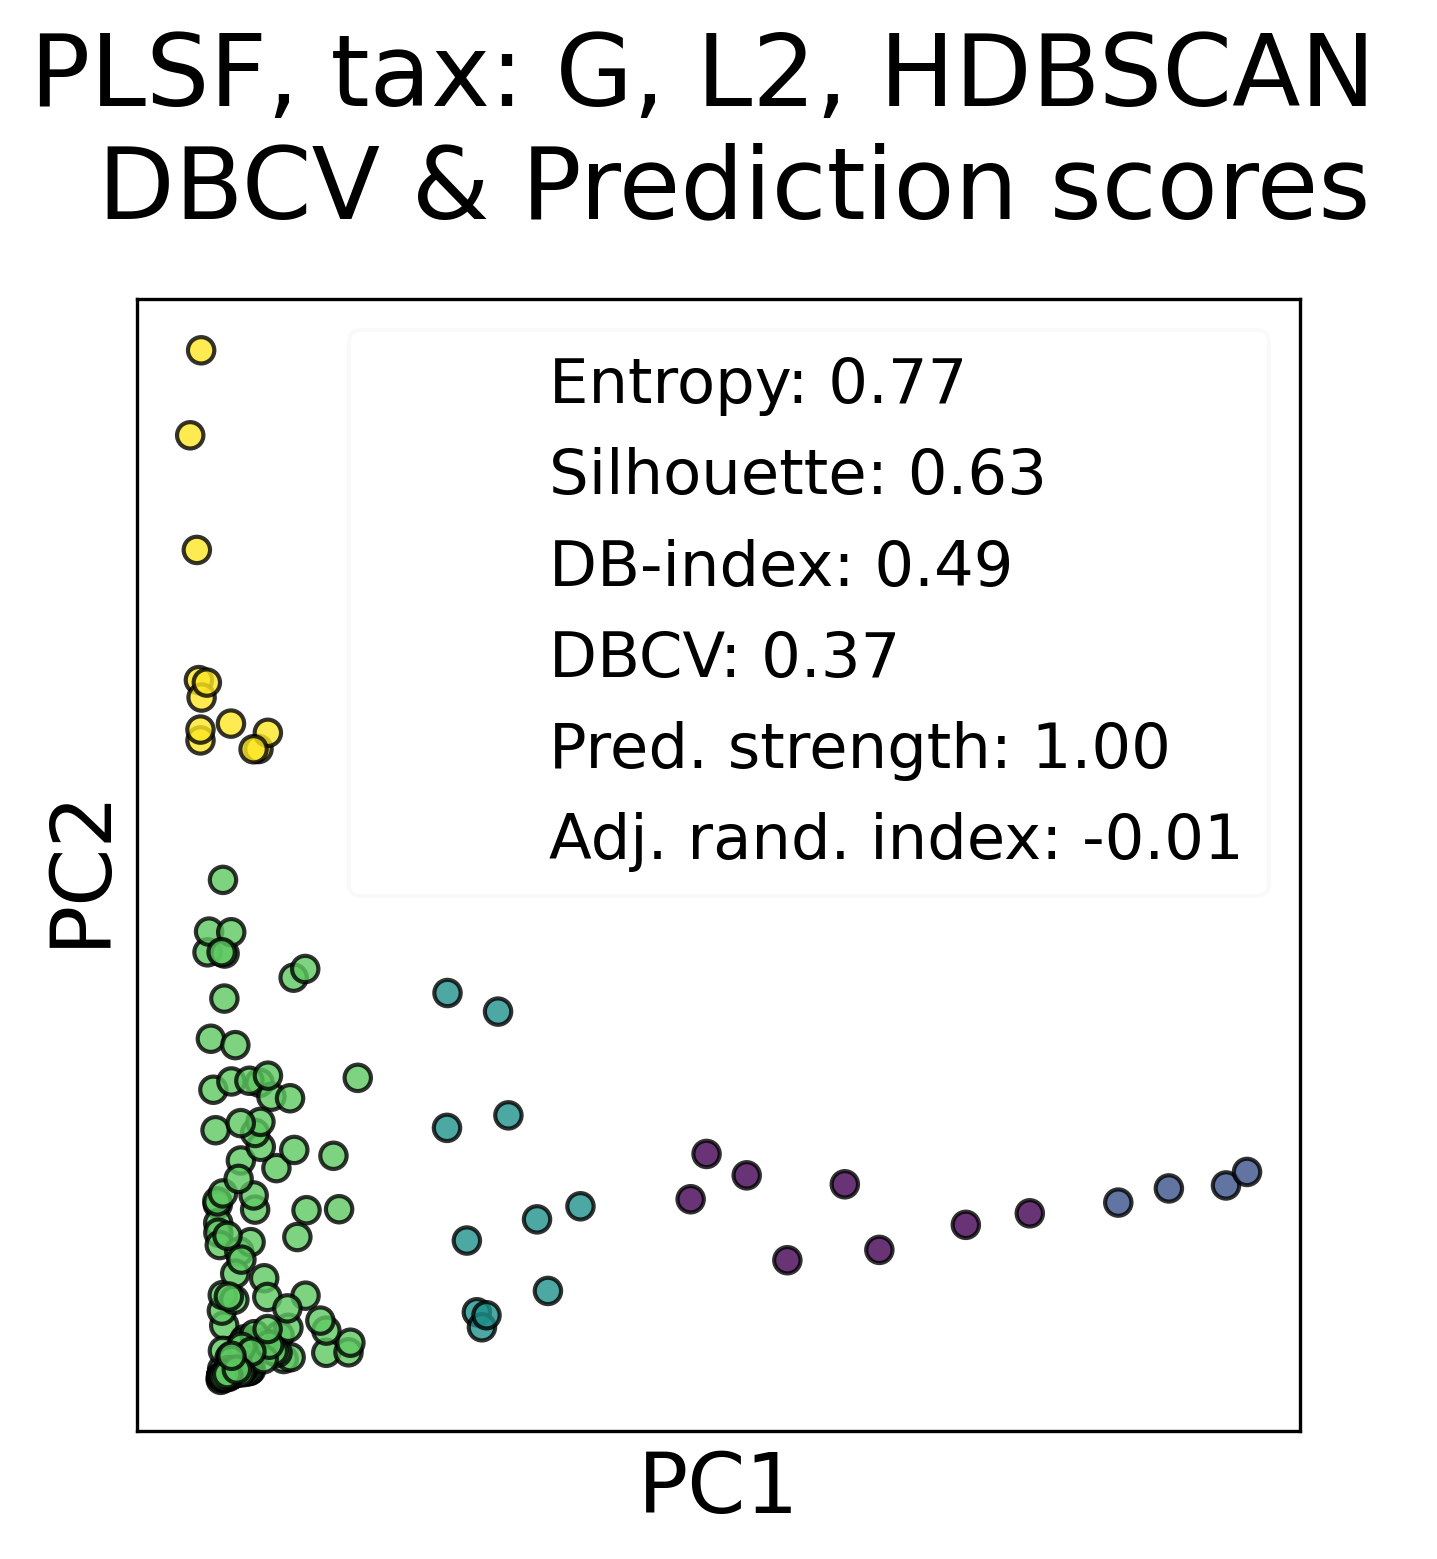

In [31]:
selection_mask_PLSF = (PLSF_df['dbcv'] > DBCV_THRESHOLD) * (PLSF_df['ps'] > PS_THRESHOLD)
df_selected = PLSF_df[selection_mask_PLSF]
idx = (df_selected['entropy']).idxmax()


best_clustering = df_selected.loc[idx]
y = best_clustering['labels']
df_mask = best_clustering['mask']
X_repr = best_clustering['representation']
X_tax = best_clustering['tax']
X_cl_method = best_clustering['cl_method']

X = data_pca['PLSF_g'][:,:2][df_mask]

RI = adjusted_rand_score(results_JS_PAM['PLSF_g']['labels'][df_mask], y)

ent, silh, dbind, dbcv, ps = np.array(best_clustering[['entropy', 'silh', 'dbind', 'dbcv', 'ps']].values, 
                                          dtype=np.float32).round(2)

plt.figure(figsize=(5,5), dpi=300)

plt.scatter(
            coord_to_pix(X[:,0]), 
            coord_to_pix(X[:,1]),
            c=y,
            edgecolors='black',
            s=40,
            alpha=0.8,
           )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])

handles, labels = plt.gca().get_legend_handles_labels()

text_handle = mlines.Line2D([], [], color='none', label='Entropy: {:.2f}'.format(ent))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Silhouette: {:.2f}'.format(silh))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DB-index: {:.2f}'.format(dbind))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DBCV: {:.2f}'.format(dbcv))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Pred. strength: {:.2f}'.format(ps))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Adj. rand. index: {:.2f}'.format(RI))
handles.append(text_handle)

# Add the arbitrary information patch to the legend handles
legend = plt.legend(handles=handles, 
                    loc='best', 
                    fontsize=15, 
                    frameon=True, 
                    fancybox=True, 
                    framealpha=0.1)

plt.title(f'PLSF, tax: G, {X_repr.upper()}, {X_cl_method} \n DBCV & Prediction scores')
plt.show()

## StCh

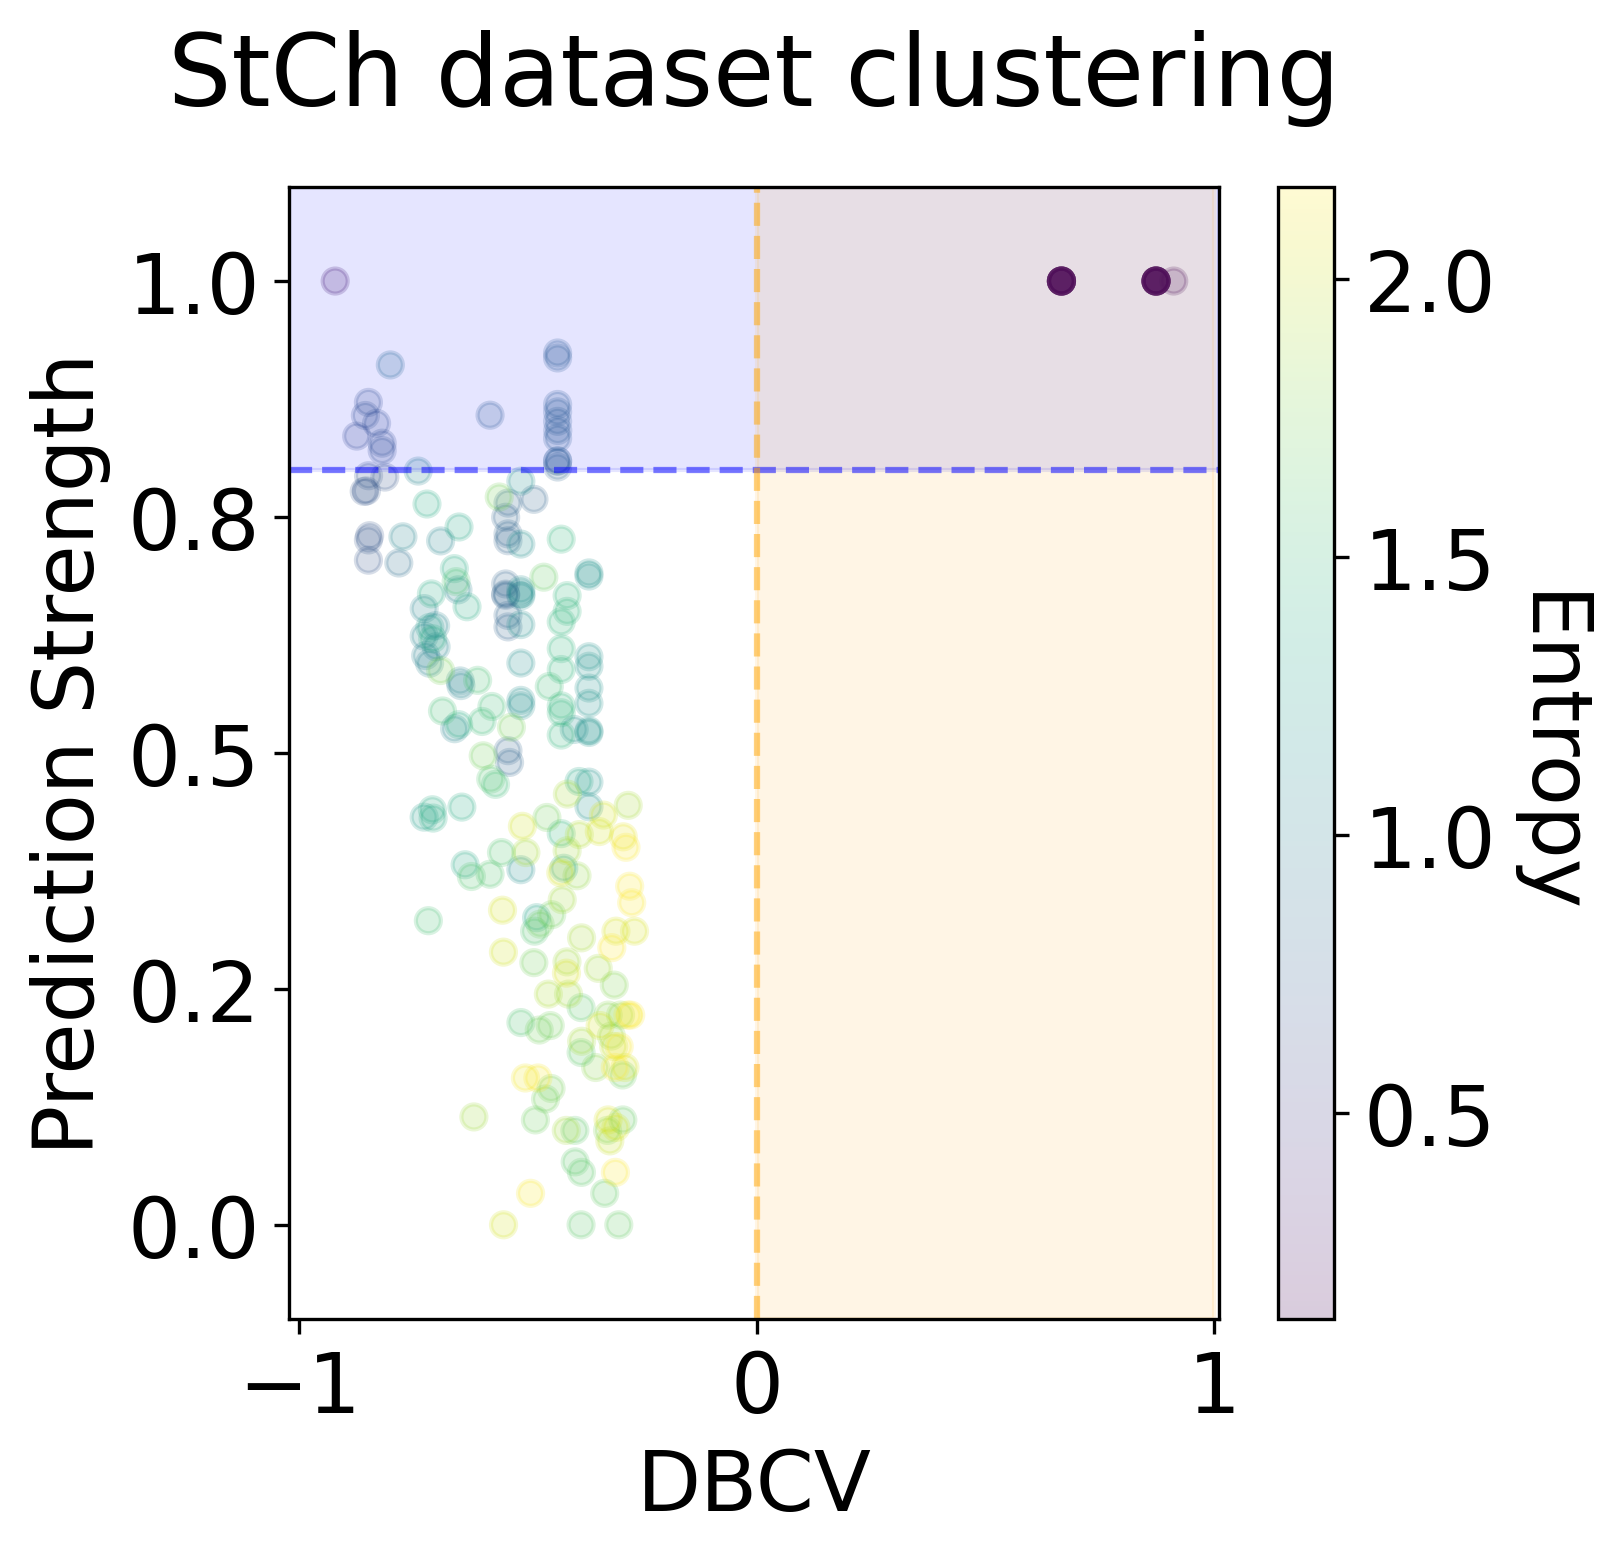

In [32]:
StCh_df = clustering_results_df_.query('dataset == "StCh"')

plot_clustering_scatter(StCh_df, 
                        x_metric_name='dbcv',
                        y_metric_name='ps', 
                        coloring_metric_name='entropy', 
                        title='StCh dataset clustering',
                        y_threshold=PS_THRESHOLD,
                        x_threshold=DBCV_THRESHOLD,
                        y_hue_line=1.2,
                        x_hue_line=1
                        )

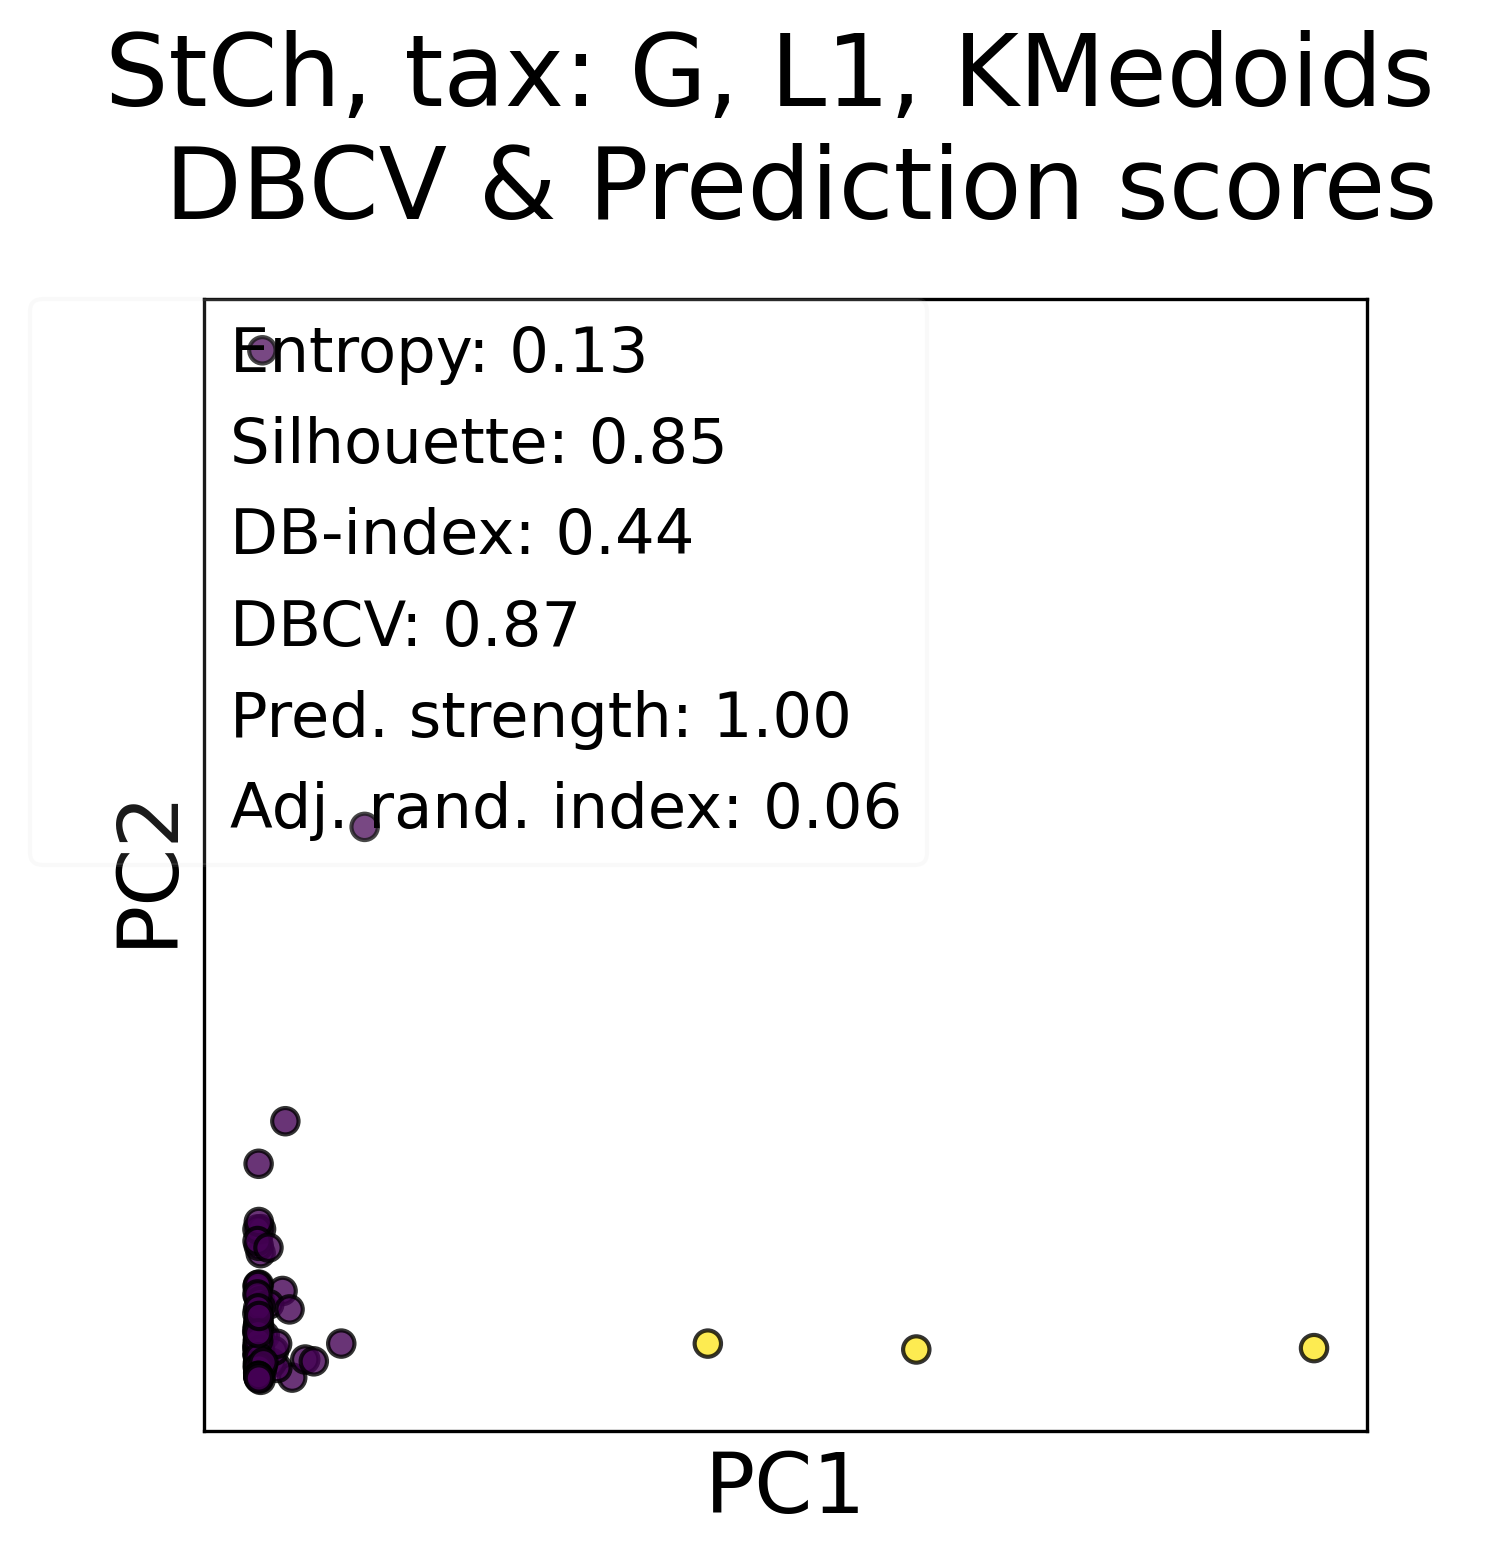

In [33]:
selection_mask_StCh = (StCh_df['dbcv'] > DBCV_THRESHOLD) * (StCh_df['ps'] > PS_THRESHOLD)
df_selected = StCh_df[selection_mask_StCh]
idx = (df_selected['entropy']).idxmax()

best_clustering = df_selected.loc[idx]
y = best_clustering['labels']
df_mask = best_clustering['mask']
X_repr = best_clustering['representation']
X_tax = best_clustering['tax']
X_cl_method = best_clustering['cl_method']

X = data_pca['StCh_g'][:,:2][df_mask]

ent, silh, dbind, dbcv, ps = np.array(best_clustering[['entropy', 'silh', 'dbind', 'dbcv', 'ps']].values, 
                                          dtype=np.float32).round(2)

    
RI = adjusted_rand_score(results_JS_PAM['StCh_g']['labels'][df_mask], y)

plt.figure(figsize=(5,5), dpi=300)

plt.scatter(
            coord_to_pix(X[:,0]), 
            coord_to_pix(X[:,1]),
            c=y,
            edgecolors='black',
            s=40,
            alpha=0.8,
           )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])

handles, labels = plt.gca().get_legend_handles_labels()

text_handle = mlines.Line2D([], [], color='none', label='Entropy: {:.2f}'.format(ent))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Silhouette: {:.2f}'.format(silh))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DB-index: {:.2f}'.format(dbind))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DBCV: {:.2f}'.format(dbcv))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Pred. strength: {:.2f}'.format(ps))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Adj. rand. index: {:.2f}'.format(RI))
handles.append(text_handle)

# Add the arbitrary information patch to the legend handles
legend = plt.legend(handles=handles, 
                    loc=(-0.15,0.5), 
                    fontsize=15, 
                    frameon=True, 
                    fancybox=True, 
                    framealpha=0.1)


plt.title(f'StCh, tax: G, {X_repr.upper()}, {X_cl_method} \n DBCV & Prediction scores')
plt.show()

## Buff

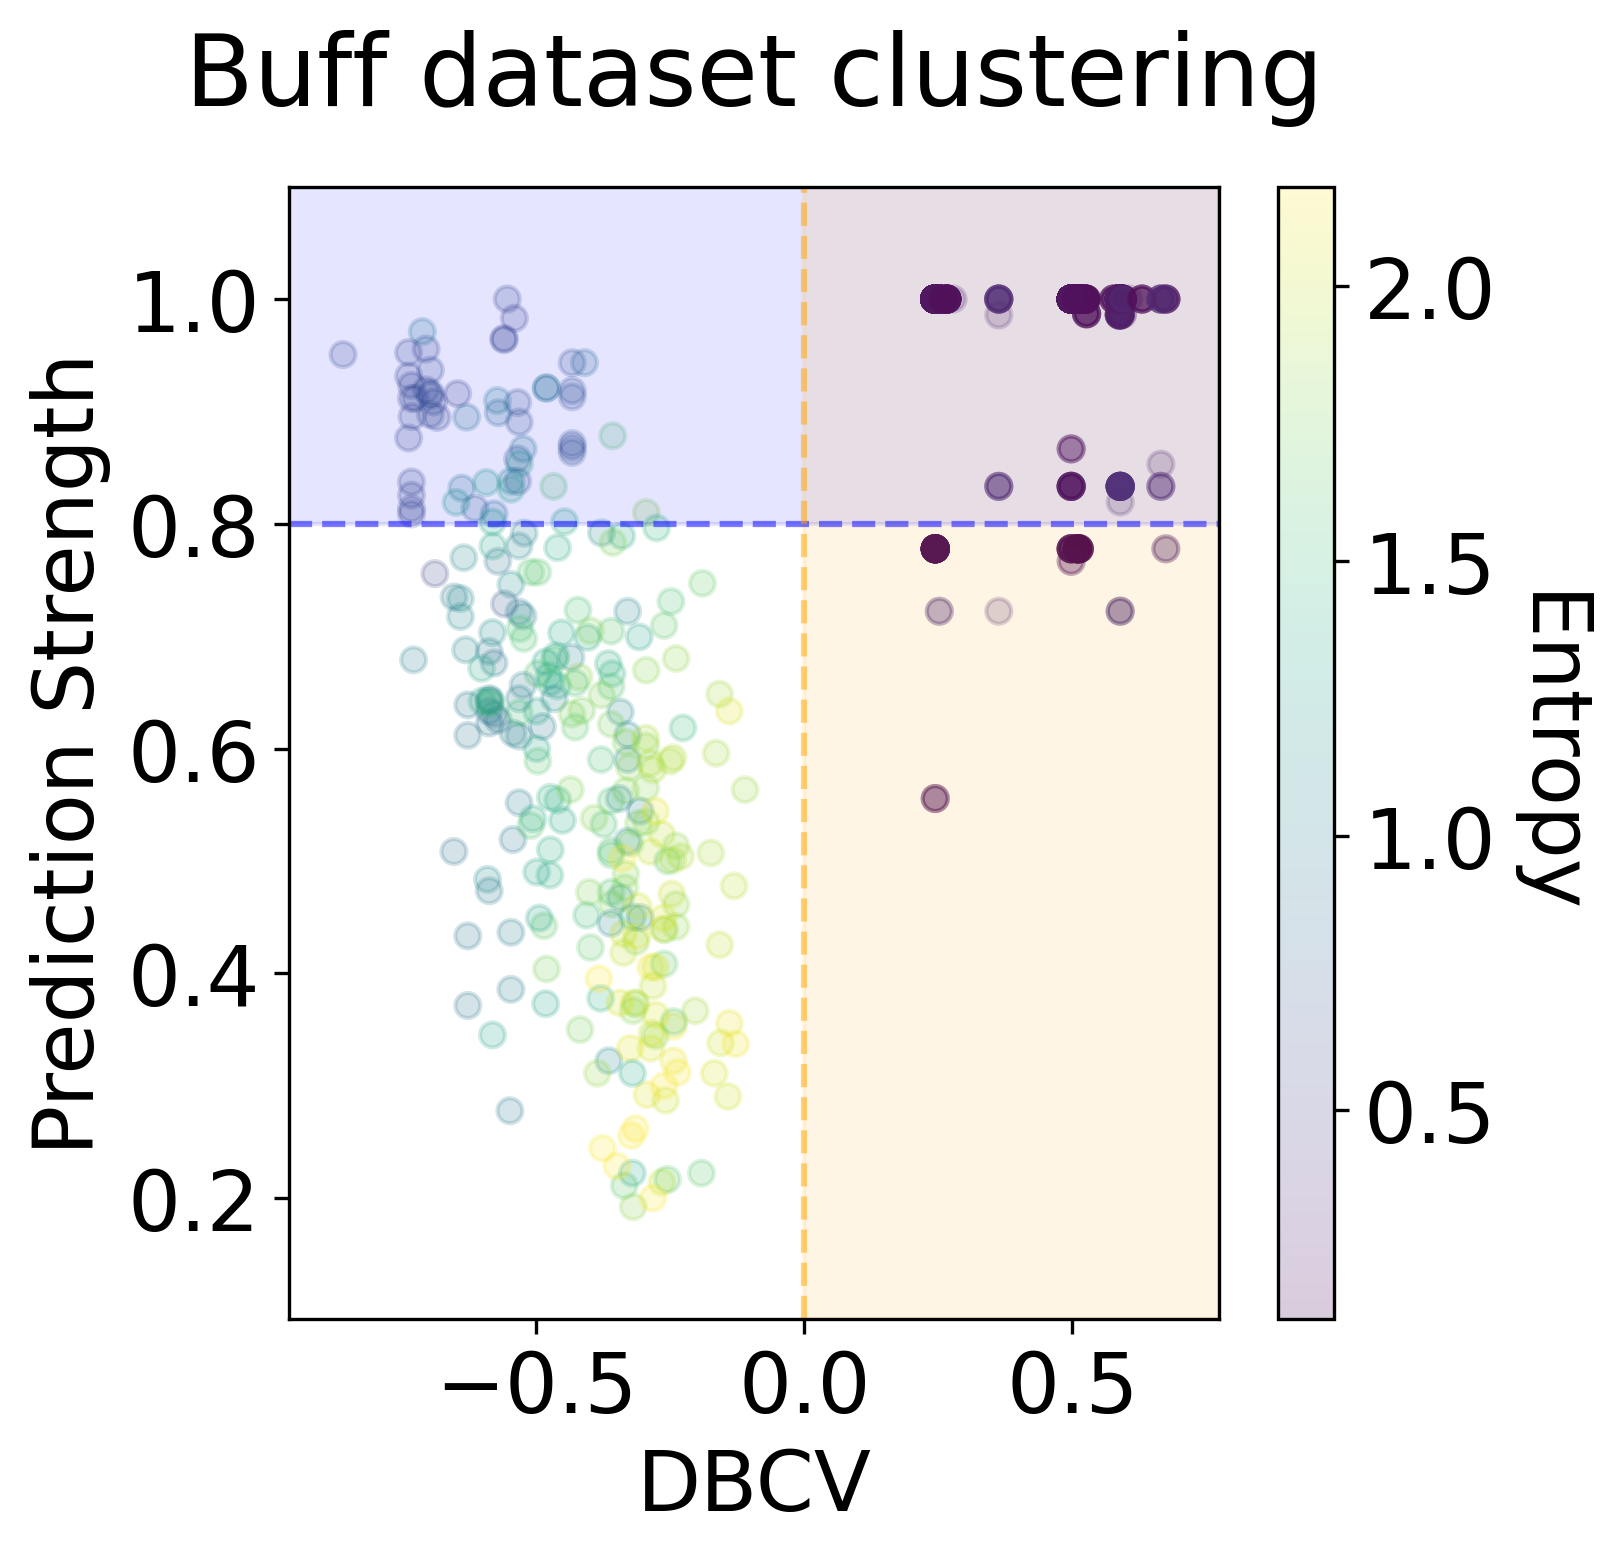

In [34]:
Buff_df_ps = clustering_results_df_.query('dataset == "Buff"')

plot_clustering_scatter(Buff_df_ps, 
                        x_metric_name='dbcv',
                        y_metric_name='ps', 
                        coloring_metric_name='entropy', 
                        title='Buff dataset clustering',
                        y_threshold=PS_THRESHOLD,
                        x_threshold=DBCV_THRESHOLD,
                        y_hue_line=1.2,
                        x_hue_line=1
                        )

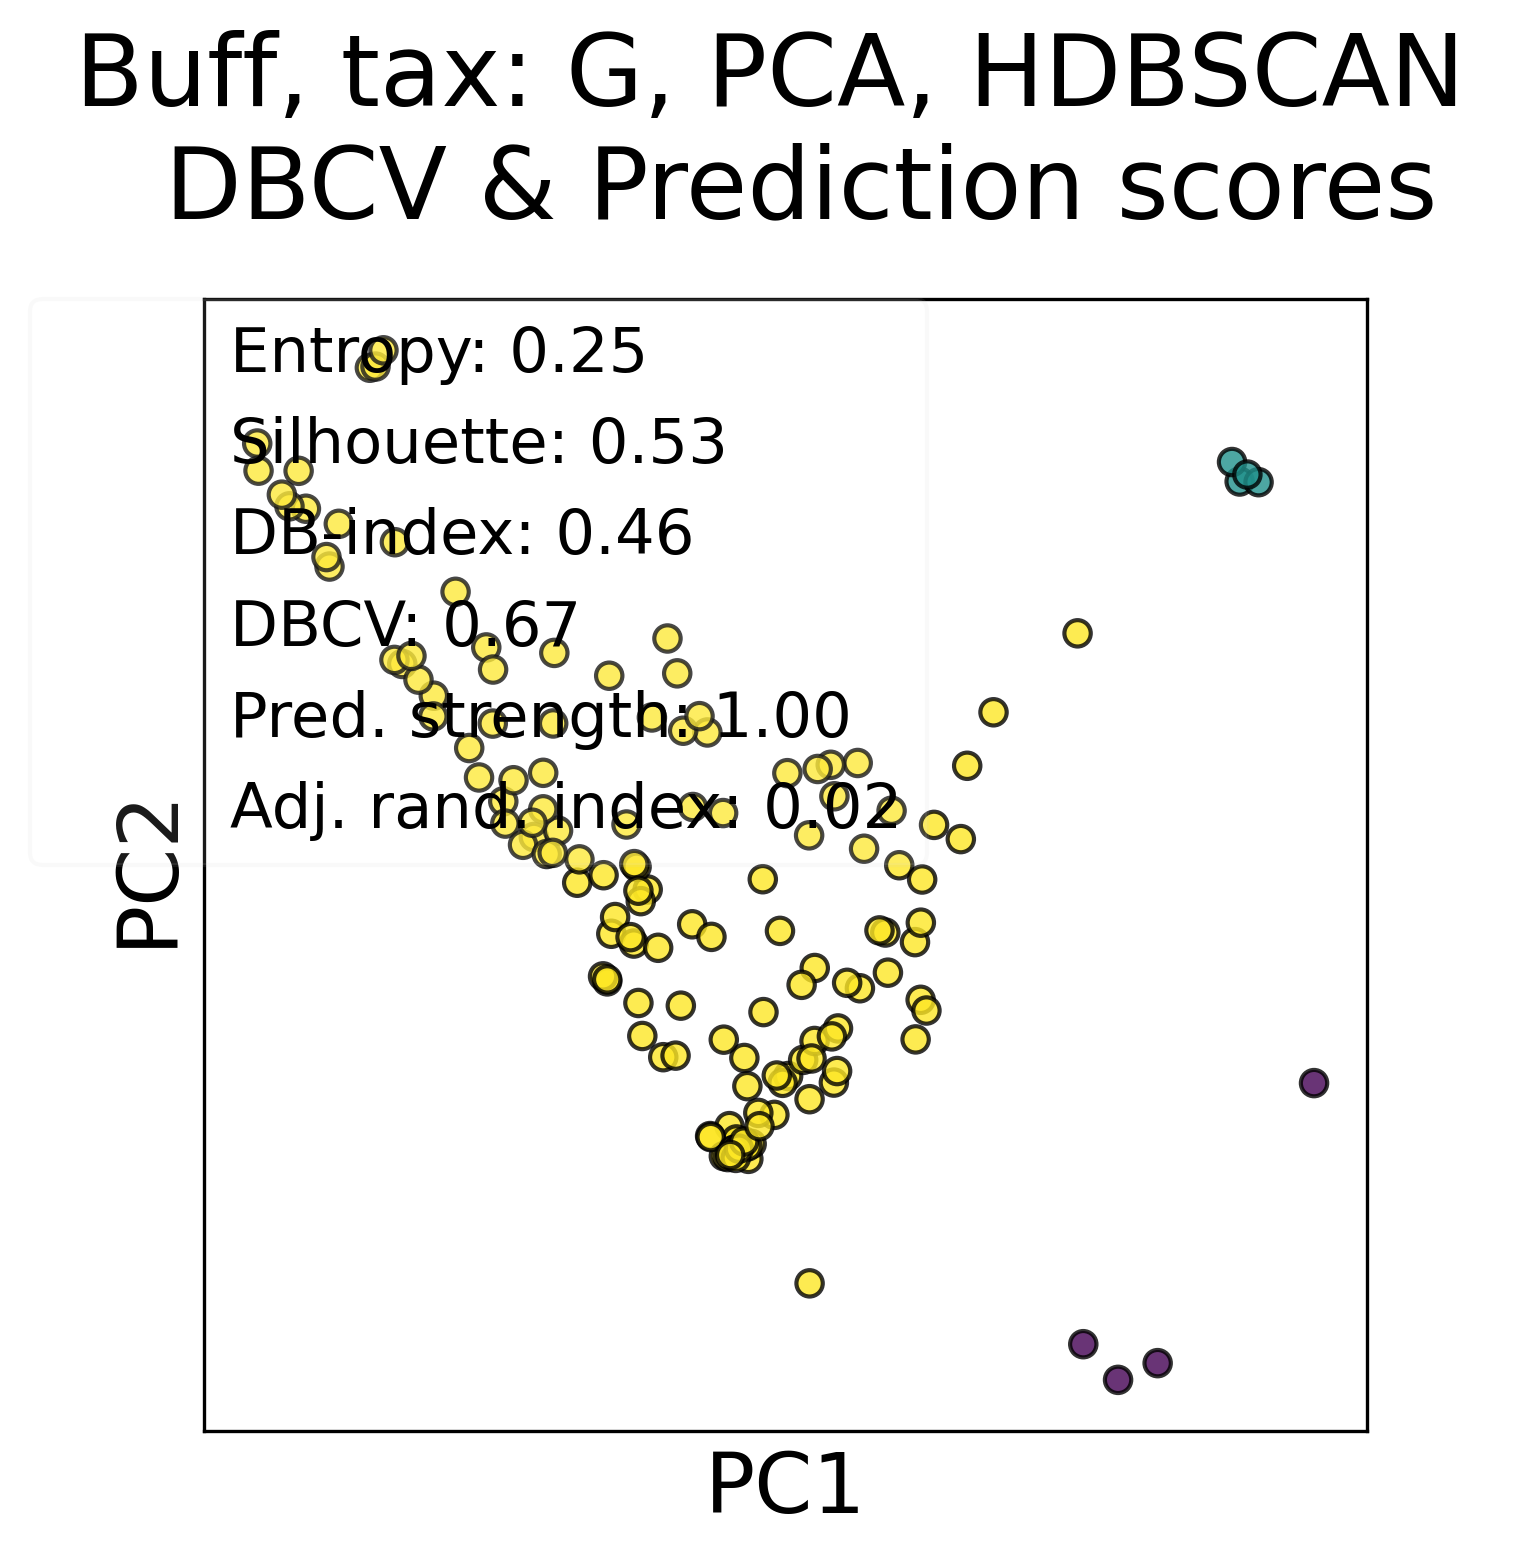

In [35]:
df_selected = Buff_df_ps[(Buff_df_ps['ps'] > PS_THRESHOLD) ]

idx = df_selected['dbcv'].idxmax()


best_clustering = df_selected.loc[idx]
y = best_clustering['labels']
df_mask = best_clustering['mask']
X_repr = best_clustering['representation']
X_tax = best_clustering['tax']
X_cl_method = best_clustering['cl_method']

X = data_pca['Buff_g'][:,:2][df_mask]

ent, silh, dbind, dbcv, ps = np.array(best_clustering[['entropy', 'silh', 'dbind', 'dbcv', 'ps']].values, 
                                          dtype=np.float32).round(2)

RI = adjusted_rand_score(results_JS_PAM['Buff_g']['labels'][df_mask], y)

plt.figure(figsize=(5,5), dpi=300)

plt.scatter(
            coord_to_pix(X[:,0]), 
            coord_to_pix(X[:,1]),
            c=y,
            edgecolors='black',
            s=40,
            alpha=0.8,
           )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])

handles, labels = plt.gca().get_legend_handles_labels()

text_handle = mlines.Line2D([], [], color='none', label='Entropy: {:.2f}'.format(ent))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Silhouette: {:.2f}'.format(silh))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DB-index: {:.2f}'.format(dbind))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DBCV: {:.2f}'.format(dbcv))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Pred. strength: {:.2f}'.format(ps))
handles.append(text_handle)


text_handle = mlines.Line2D([], [], color='none', label='Adj. rand. index: {:.2f}'.format(RI))
handles.append(text_handle)


# Add the arbitrary information patch to the legend handles
legend = plt.legend(handles=handles, 
                    loc=(-0.15,0.5), 
                    fontsize=15, 
                    frameon=True, 
                    fancybox=True, 
                    framealpha=0.1)
plt.title(f'Buff, tax: G, {X_repr.upper()}, {X_cl_method} \n DBCV & Prediction scores')
plt.show()

## Champ

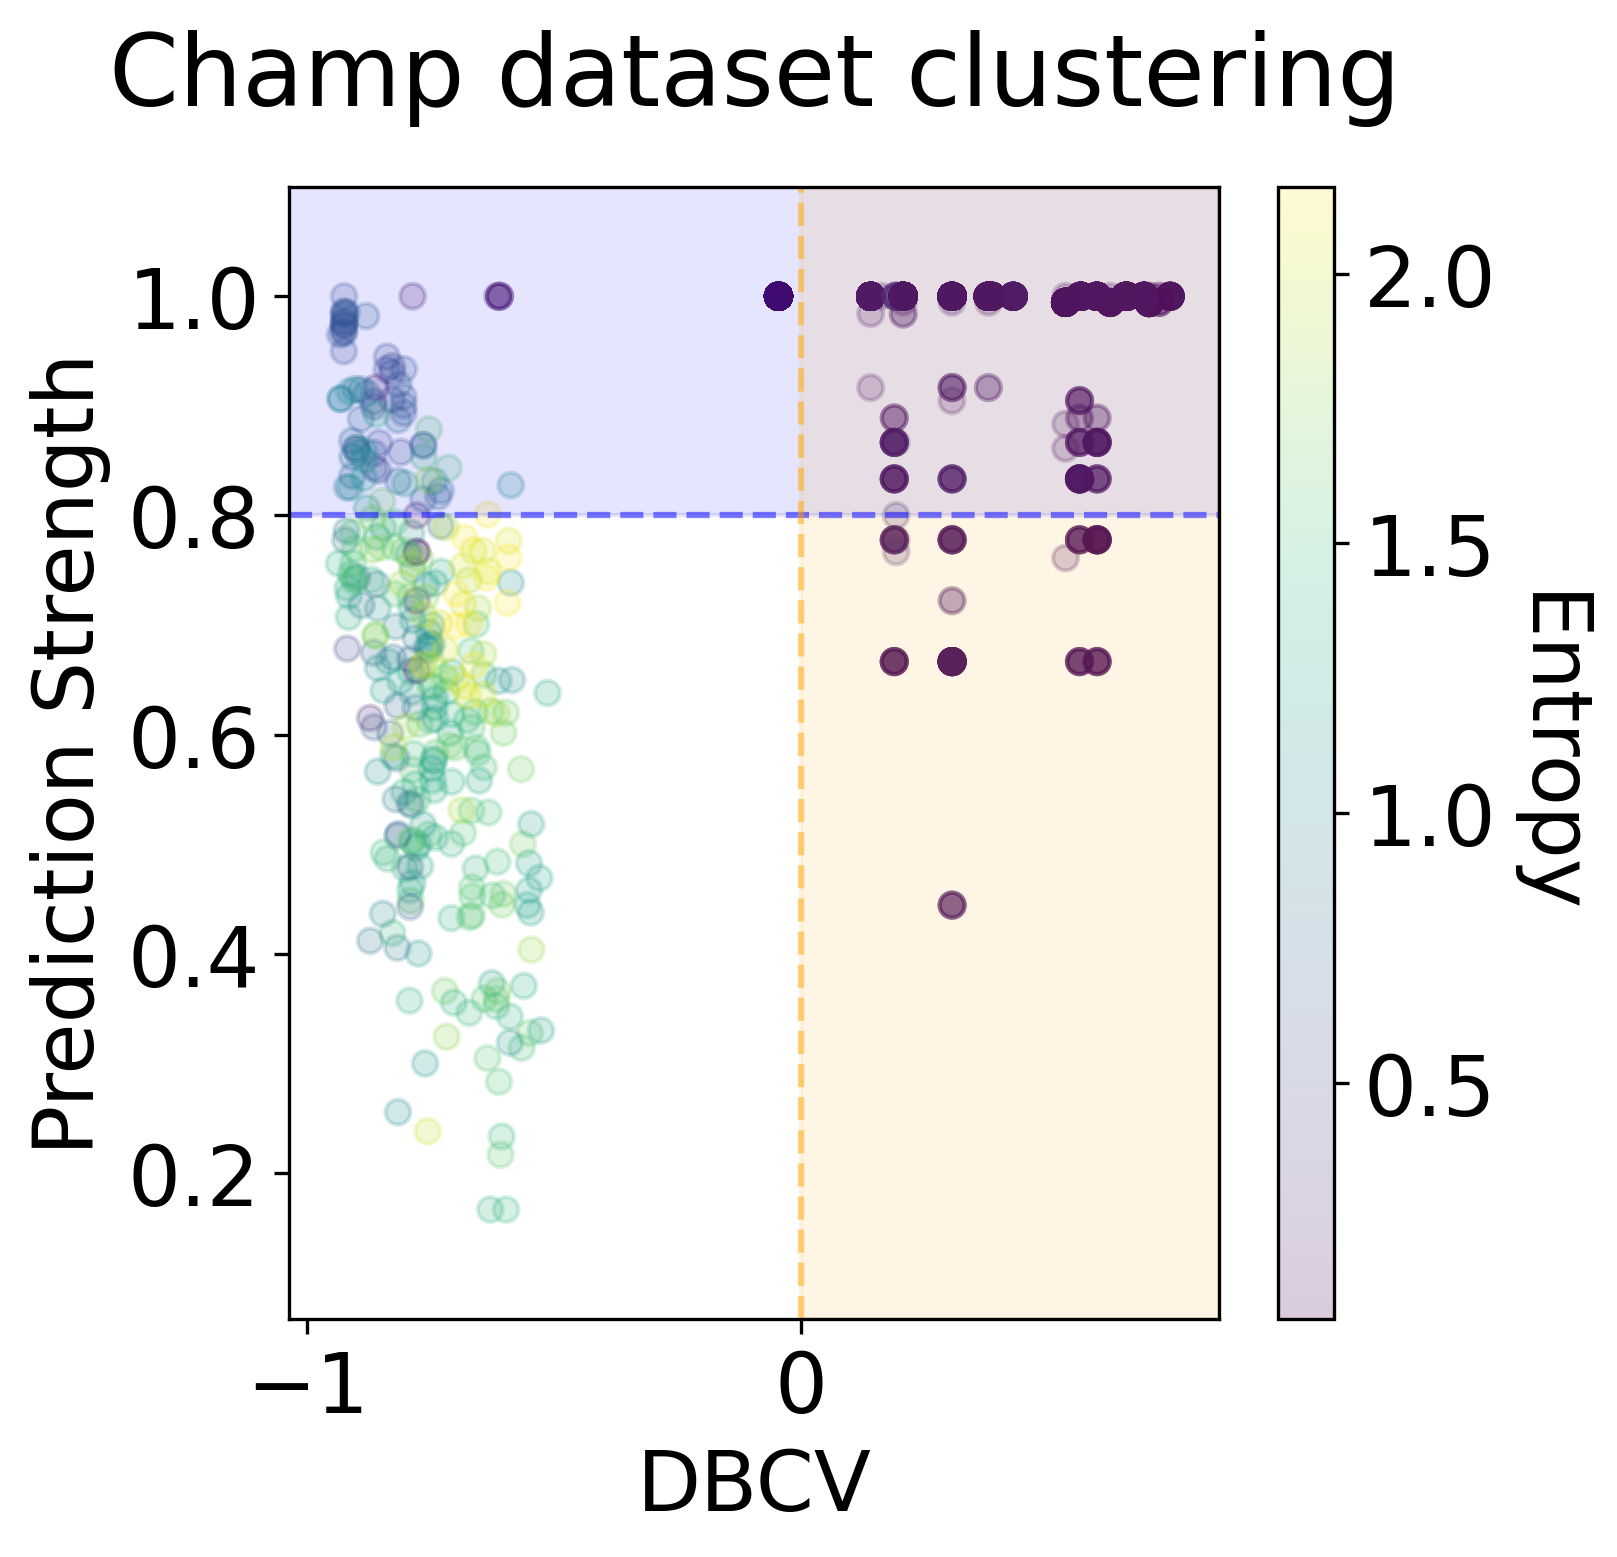

In [36]:
Champ_df_ps = clustering_results_df_.query('dataset == "Champ"')

plot_clustering_scatter(Champ_df_ps, 
                        x_metric_name='dbcv',
                        y_metric_name='ps', 
                        coloring_metric_name='entropy', 
                        title='Champ dataset clustering',
                        y_threshold=PS_THRESHOLD,
                        x_threshold=DBCV_THRESHOLD,
                        y_hue_line=1.2,
                        x_hue_line=1
                        )

In [37]:
df_selected = Champ_df_ps[(Champ_df_ps['ps'] > PS_THRESHOLD) ]

idx = df_selected['dbcv'].idxmax()


best_clustering = df_selected.loc[idx]
y = best_clustering['labels']
df_mask = best_clustering['mask']
X_repr = best_clustering['representation']
X_tax = best_clustering['tax']
X_cl_method = best_clustering['cl_method']

X = data_pca['Champ_g'][:,:2][df_mask]

ent, silh, dbind, dbcv, ps = np.array(best_clustering[['entropy', 'silh', 'dbind', 'dbcv', 'ps']].values, 
                                          dtype=np.float32).round(2)

RI = adjusted_rand_score(results_JS_PAM['Champ_g']['labels'][df_mask], y)

plt.figure(figsize=(5,5), dpi=300)

plt.scatter(
            coord_to_pix(X[:,0]), 
            coord_to_pix(X[:,1]),
            c=y,
            edgecolors='black',
            s=40,
            alpha=0.8,
           )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])

handles, labels = plt.gca().get_legend_handles_labels()

text_handle = mlines.Line2D([], [], color='none', label='Entropy: {:.2f}'.format(ent))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Silhouette: {:.2f}'.format(silh))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DB-index: {:.2f}'.format(dbind))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DBCV: {:.2f}'.format(dbcv))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Pred. strength: {:.2f}'.format(ps))
handles.append(text_handle)


text_handle = mlines.Line2D([], [], color='none', label='Adj. rand. index: {:.2f}'.format(RI))
handles.append(text_handle)


# Add the arbitrary information patch to the legend handles
legend = plt.legend(handles=handles, 
                    loc=(-0.15,0.5), 
                    fontsize=15, 
                    frameon=True, 
                    fancybox=True, 
                    framealpha=0.1)
plt.title(f'Champ, tax: G, {X_repr.upper()}, {X_cl_method} \n DBCV & Prediction scores')
plt.show()

KeyError: 'Champ_g'

## Conest

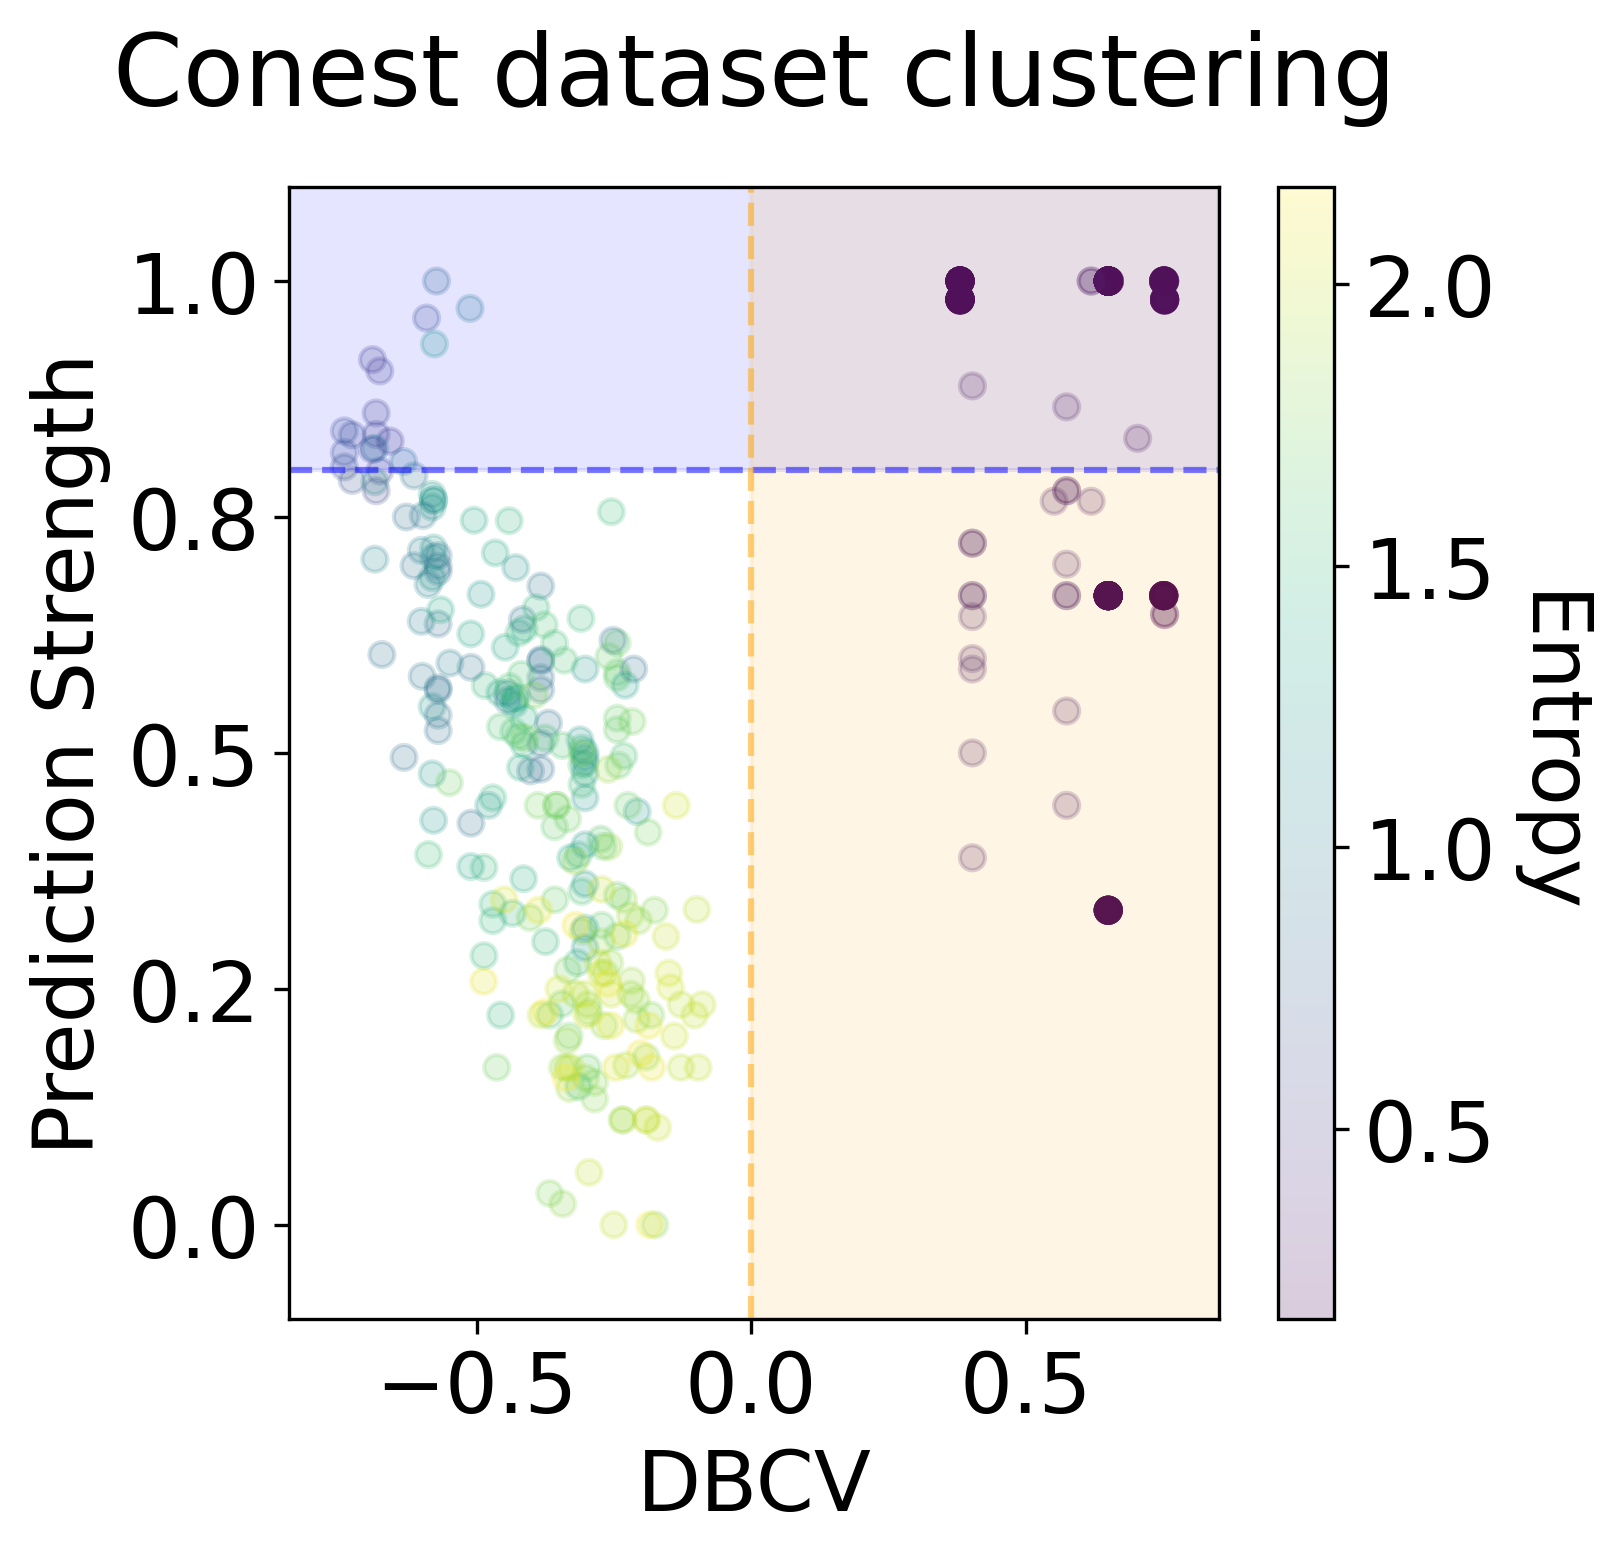

In [38]:
Conest_df_ps = clustering_results_df_.query('dataset == "Conest"')

plot_clustering_scatter(Conest_df_ps, 
                        x_metric_name='dbcv',
                        y_metric_name='ps', 
                        coloring_metric_name='entropy', 
                        title='Conest dataset clustering',
                        y_threshold=PS_THRESHOLD,
                        x_threshold=DBCV_THRESHOLD,
                        y_hue_line=1.2,
                        x_hue_line=1
                        )

In [39]:
df_selected = Conest_df_ps[(Conest_df_ps['ps'] > PS_THRESHOLD) ]

idx = df_selected['dbcv'].idxmax()


best_clustering = df_selected.loc[idx]
y = best_clustering['labels']
df_mask = best_clustering['mask']
X_repr = best_clustering['representation']
X_tax = best_clustering['tax']
X_cl_method = best_clustering['cl_method']

X = data_pca['Conest_g'][:,:2][df_mask]

ent, silh, dbind, dbcv, ps = np.array(best_clustering[['entropy', 'silh', 'dbind', 'dbcv', 'ps']].values, 
                                          dtype=np.float32).round(2)

RI = adjusted_rand_score(results_JS_PAM['Conest_g']['labels'][df_mask], y)

plt.figure(figsize=(5,5), dpi=300)

plt.scatter(
            coord_to_pix(X[:,0]), 
            coord_to_pix(X[:,1]),
            c=y,
            edgecolors='black',
            s=40,
            alpha=0.8,
           )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])

handles, labels = plt.gca().get_legend_handles_labels()

text_handle = mlines.Line2D([], [], color='none', label='Entropy: {:.2f}'.format(ent))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Silhouette: {:.2f}'.format(silh))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DB-index: {:.2f}'.format(dbind))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DBCV: {:.2f}'.format(dbcv))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Pred. strength: {:.2f}'.format(ps))
handles.append(text_handle)


text_handle = mlines.Line2D([], [], color='none', label='Adj. rand. index: {:.2f}'.format(RI))
handles.append(text_handle)


# Add the arbitrary information patch to the legend handles
legend = plt.legend(handles=handles, 
                    loc=(-0.15,0.5), 
                    fontsize=15, 
                    frameon=True, 
                    fancybox=True, 
                    framealpha=0.1)
plt.title(f'Conest, tax: G, {X_repr.upper()}, {X_cl_method} \n DBCV & Prediction scores')
plt.show()

KeyError: 'Conest_g'

## rotor

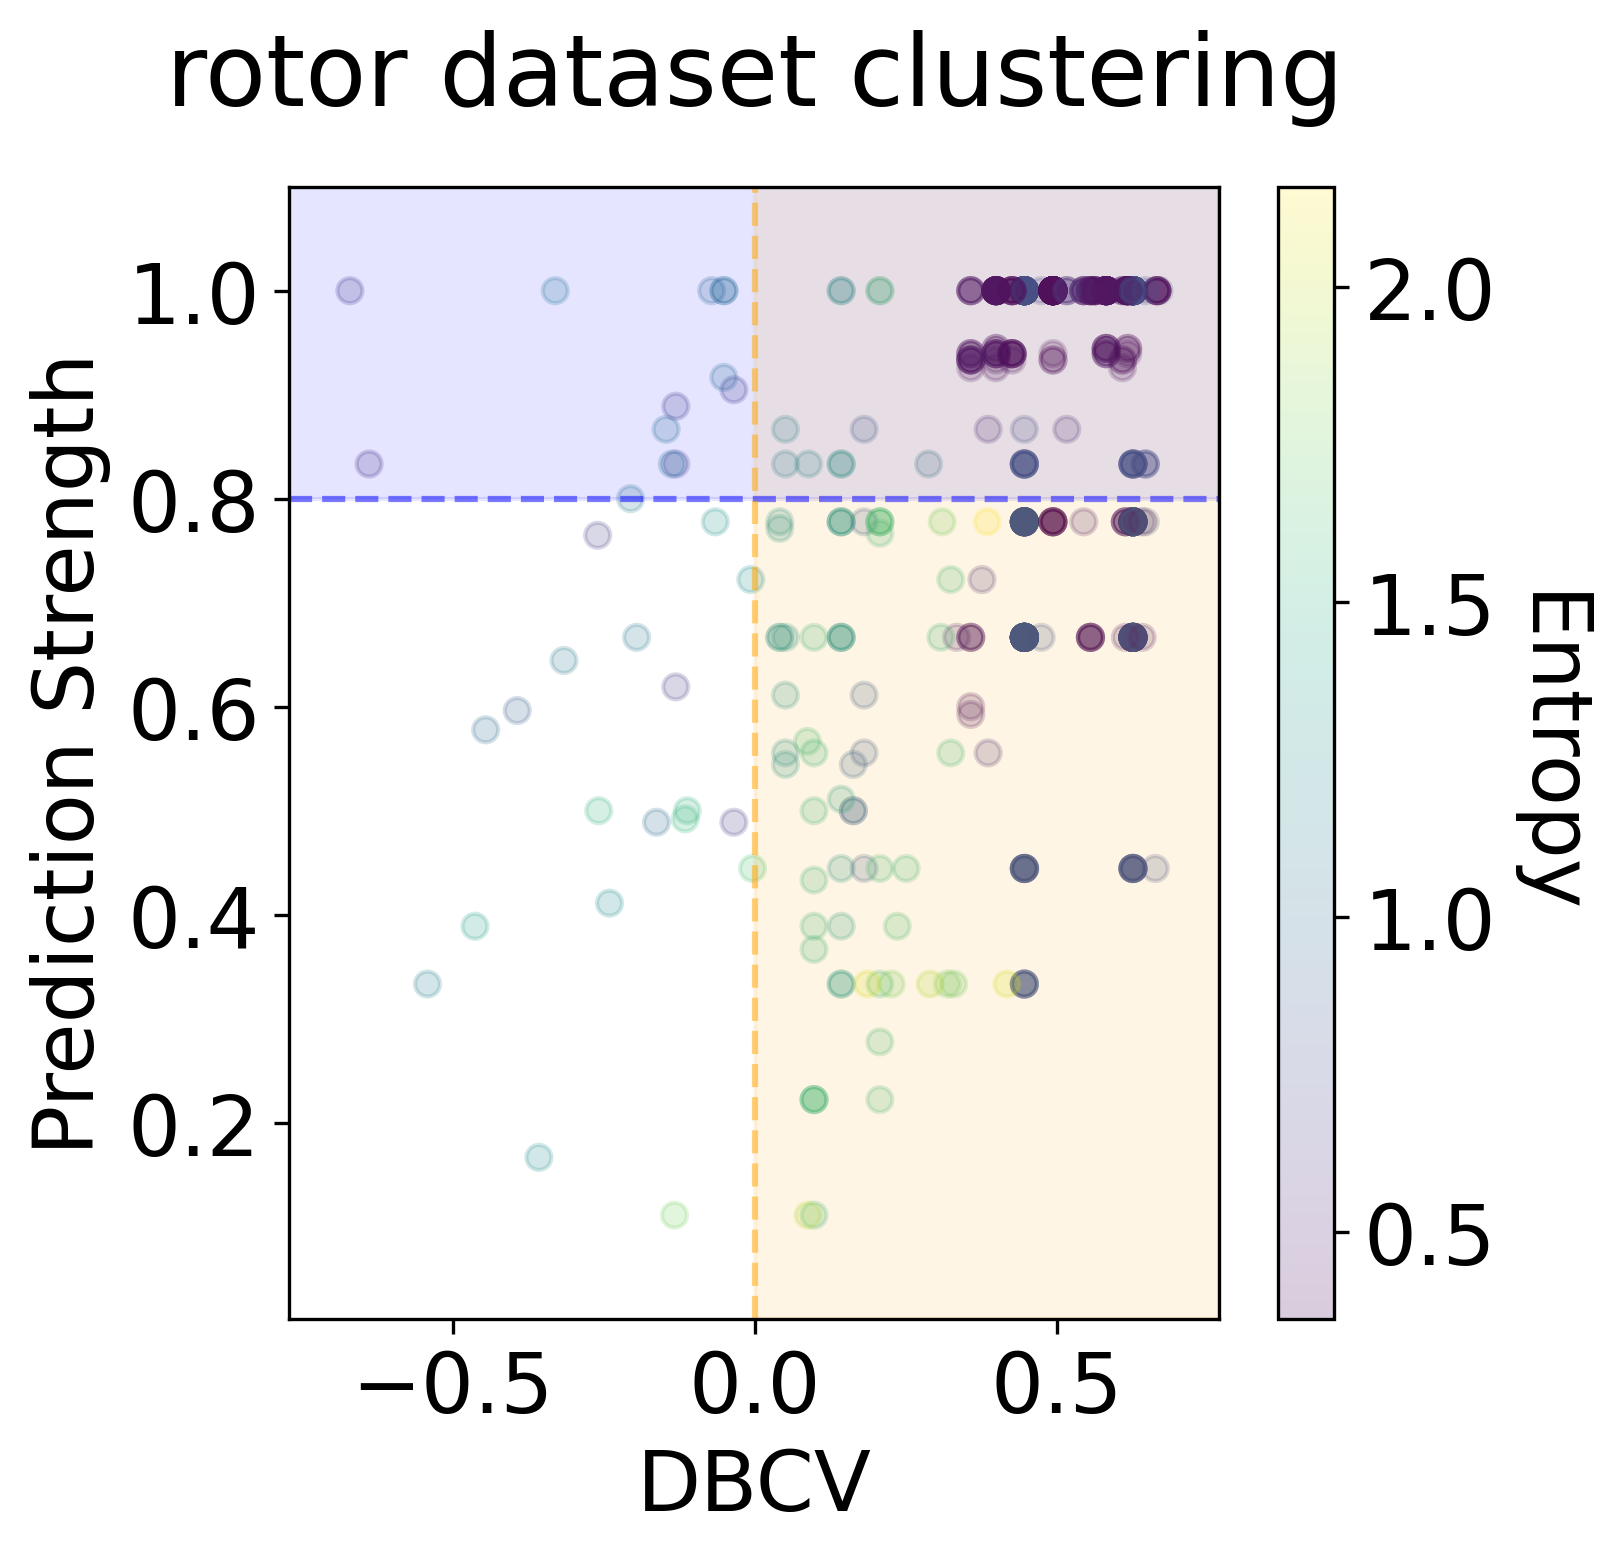

In [40]:
rotor_df_ps = clustering_results_df_.query('dataset == "rotor"')

plot_clustering_scatter(rotor_df_ps, 
                        x_metric_name='dbcv',
                        y_metric_name='ps', 
                        coloring_metric_name='entropy', 
                        title='rotor dataset clustering',
                        y_threshold=PS_THRESHOLD,
                        x_threshold=DBCV_THRESHOLD,
                        y_hue_line=1.2,
                        x_hue_line=1
                        )

In [41]:
df_selected = rotor_df_ps[(rotor_df_ps['ps'] > PS_THRESHOLD) ]

idx = df_selected['dbcv'].idxmax()


best_clustering = df_selected.loc[idx]
y = best_clustering['labels']
df_mask = best_clustering['mask']
X_repr = best_clustering['representation']
X_tax = best_clustering['tax']
X_cl_method = best_clustering['cl_method']

X = data_pca['rotor_g'][:,:2][df_mask]

ent, silh, dbind, dbcv, ps = np.array(best_clustering[['entropy', 'silh', 'dbind', 'dbcv', 'ps']].values, 
                                          dtype=np.float32).round(2)

RI = adjusted_rand_score(results_JS_PAM['rotor_g']['labels'][df_mask], y)

plt.figure(figsize=(5,5), dpi=300)

plt.scatter(
            coord_to_pix(X[:,0]), 
            coord_to_pix(X[:,1]),
            c=y,
            edgecolors='black',
            s=40,
            alpha=0.8,
           )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])

handles, labels = plt.gca().get_legend_handles_labels()

text_handle = mlines.Line2D([], [], color='none', label='Entropy: {:.2f}'.format(ent))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Silhouette: {:.2f}'.format(silh))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DB-index: {:.2f}'.format(dbind))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DBCV: {:.2f}'.format(dbcv))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Pred. strength: {:.2f}'.format(ps))
handles.append(text_handle)


text_handle = mlines.Line2D([], [], color='none', label='Adj. rand. index: {:.2f}'.format(RI))
handles.append(text_handle)


# Add the arbitrary information patch to the legend handles
legend = plt.legend(handles=handles, 
                    loc=(-0.15,0.5), 
                    fontsize=15, 
                    frameon=True, 
                    fancybox=True, 
                    framealpha=0.1)
plt.title(f'rotor, tax: G, {X_repr.upper()}, {X_cl_method} \n DBCV & Prediction scores')
plt.show()

KeyError: 'rotor_g'

## otherLake

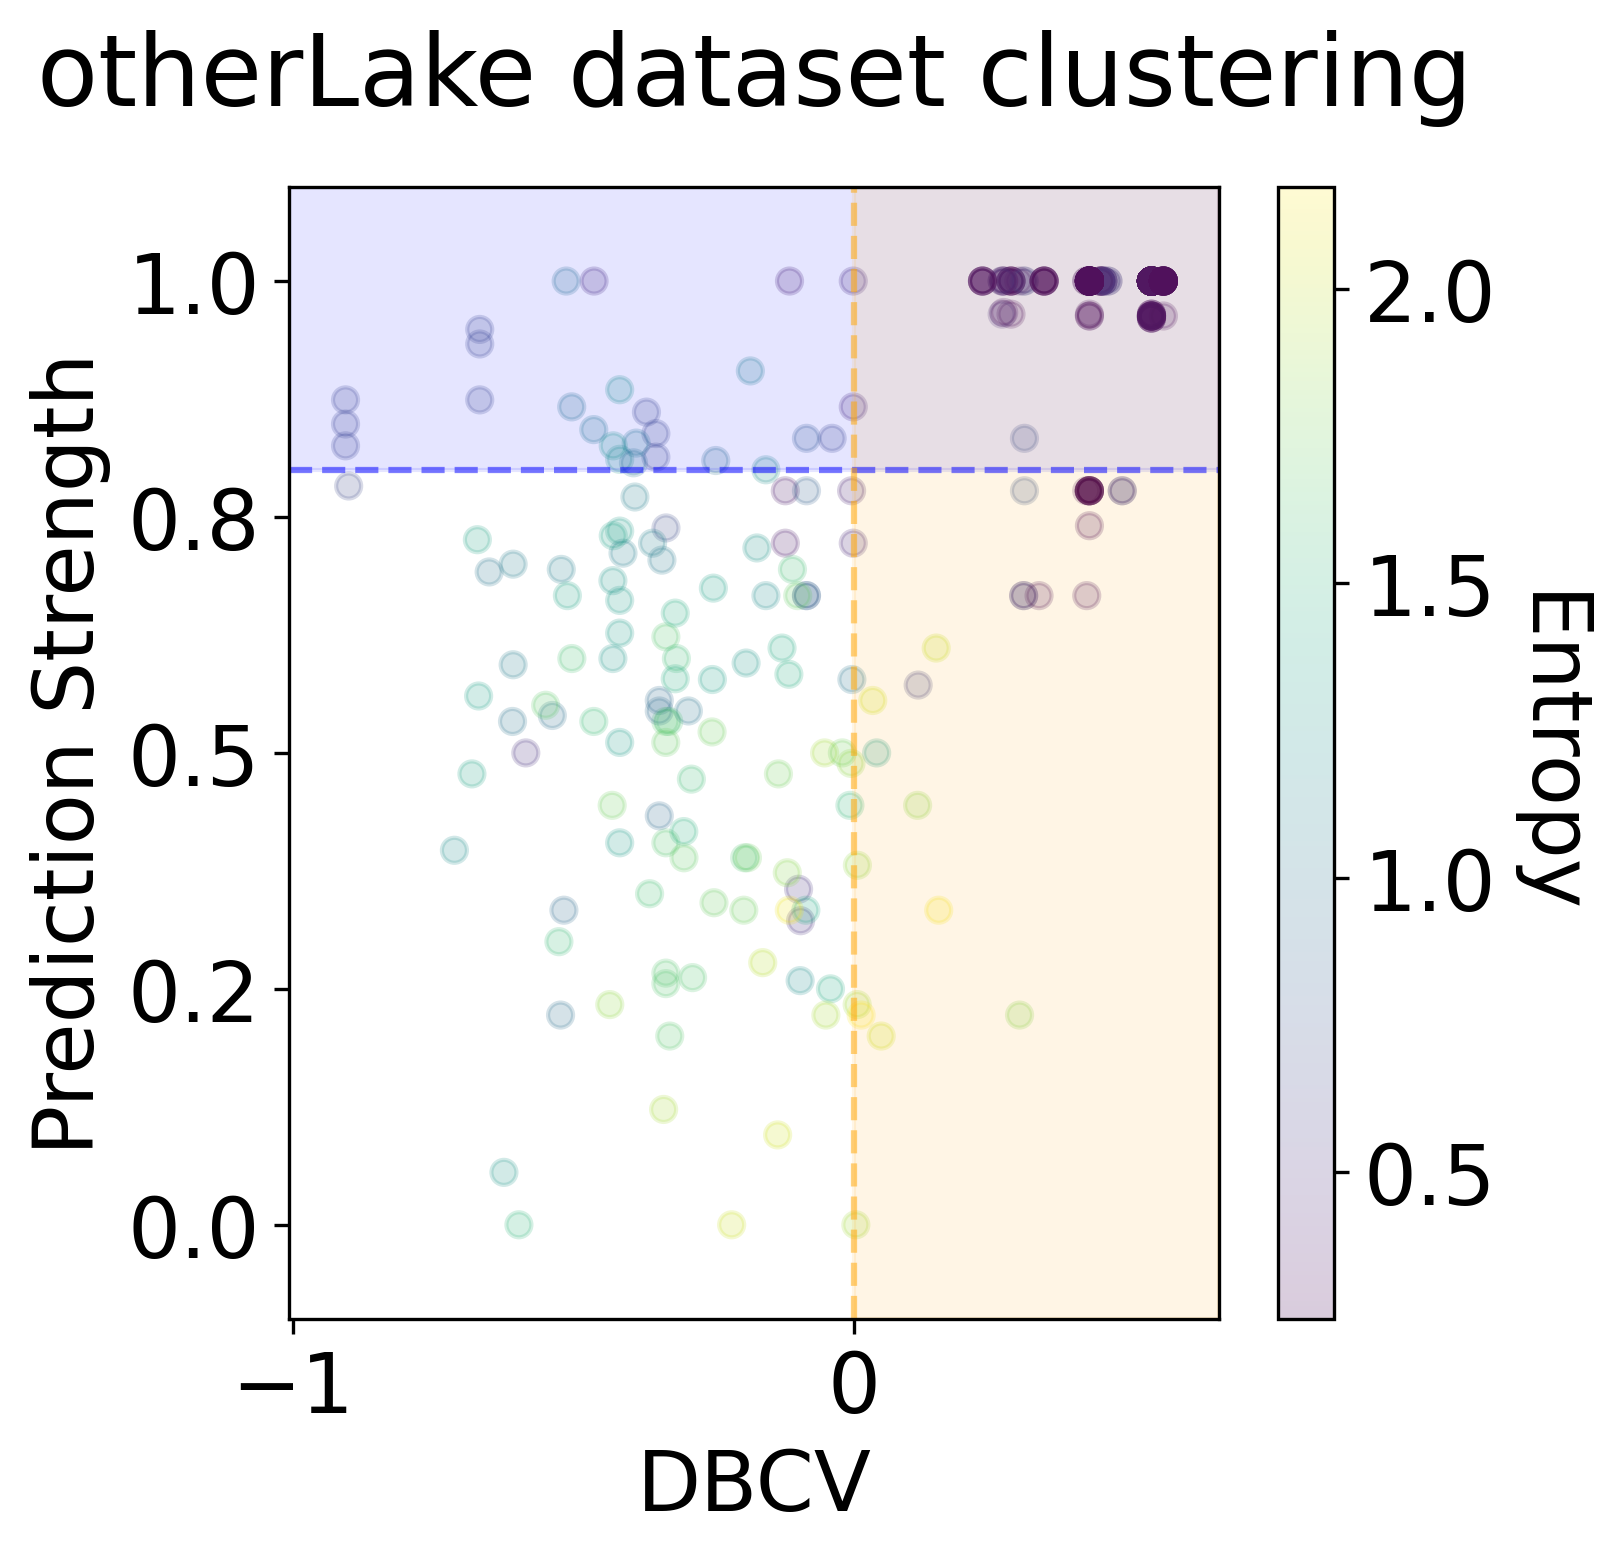

In [42]:
otherLake_df_ps = clustering_results_df_.query('dataset == "otherLake"')

plot_clustering_scatter(otherLake_df_ps, 
                        x_metric_name='dbcv',
                        y_metric_name='ps', 
                        coloring_metric_name='entropy', 
                        title='otherLake dataset clustering',
                        y_threshold=PS_THRESHOLD,
                        x_threshold=DBCV_THRESHOLD,
                        y_hue_line=1.2,
                        x_hue_line=1
                        )

In [43]:
df_selected = otherLake_df_ps[(otherLake_df_ps['ps'] > PS_THRESHOLD) ]

idx = df_selected['dbcv'].idxmax()


best_clustering = df_selected.loc[idx]
y = best_clustering['labels']
df_mask = best_clustering['mask']
X_repr = best_clustering['representation']
X_tax = best_clustering['tax']
X_cl_method = best_clustering['cl_method']

X = data_pca['otherLake_g'][:,:2][df_mask]

ent, silh, dbind, dbcv, ps = np.array(best_clustering[['entropy', 'silh', 'dbind', 'dbcv', 'ps']].values, 
                                          dtype=np.float32).round(2)

RI = adjusted_rand_score(results_JS_PAM['otherLake_g']['labels'][df_mask], y)

plt.figure(figsize=(5,5), dpi=300)

plt.scatter(
            coord_to_pix(X[:,0]), 
            coord_to_pix(X[:,1]),
            c=y,
            edgecolors='black',
            s=40,
            alpha=0.8,
           )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])

handles, labels = plt.gca().get_legend_handles_labels()

text_handle = mlines.Line2D([], [], color='none', label='Entropy: {:.2f}'.format(ent))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Silhouette: {:.2f}'.format(silh))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DB-index: {:.2f}'.format(dbind))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DBCV: {:.2f}'.format(dbcv))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Pred. strength: {:.2f}'.format(ps))
handles.append(text_handle)


text_handle = mlines.Line2D([], [], color='none', label='Adj. rand. index: {:.2f}'.format(RI))
handles.append(text_handle)


# Add the arbitrary information patch to the legend handles
legend = plt.legend(handles=handles, 
                    loc=(-0.15,0.5), 
                    fontsize=15, 
                    frameon=True, 
                    fancybox=True, 
                    framealpha=0.1)
plt.title(f'otherLake, tax: G, {X_repr.upper()}, {X_cl_method} \n DBCV & Prediction scores')
plt.show()

KeyError: 'otherLake_g'